# Examining Free Energy (Stability) of Inverted Repeats in SV Flanks

Summary Statistics for hap1:
count    202133.000000
mean         -5.483179
std           7.150551
min        -103.000000
25%          -6.400000
50%          -3.200000
75%          -1.200000
max           1.700000
Name: Free_Energy, dtype: float64

Summary Statistics for hap2:
count    207431.000000
mean         -5.611661
std           7.280783
min        -322.000000
25%          -6.400000
50%          -3.300000
75%          -1.300000
max           1.700000
Name: Free_Energy, dtype: float64


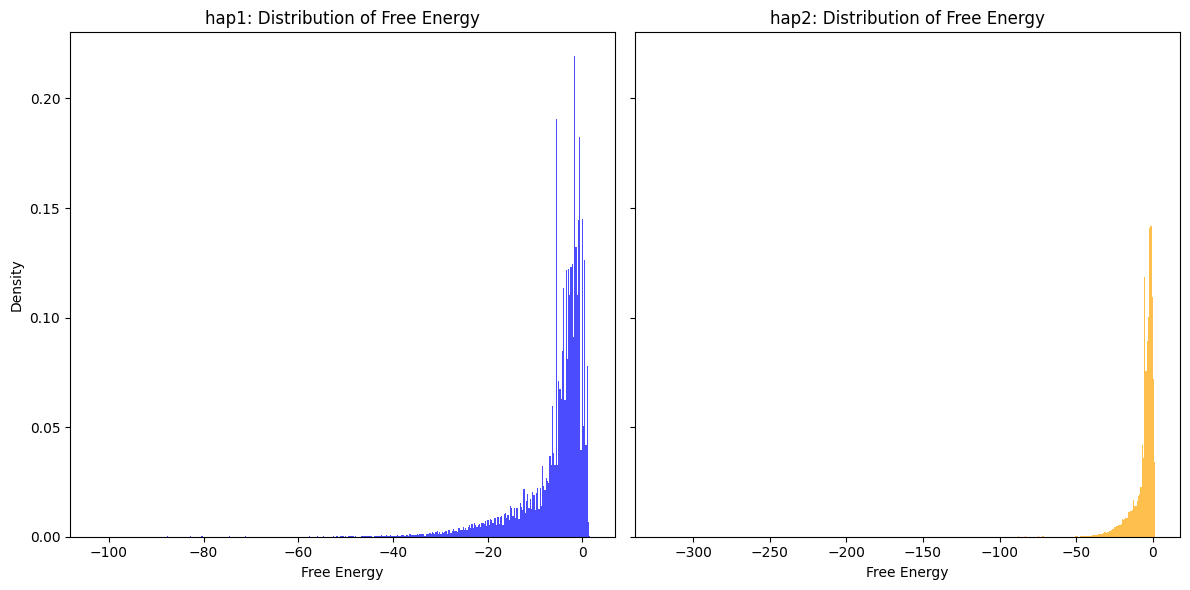

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data for hap1 and hap2
hap1_file = "/home/alextu/scratch/free_energy_IRs/flanking_sequences_HG00096_hap1_IR_free_energy.tsv"
hap2_file = "/home/alextu/scratch/free_energy_IRs/flanking_sequences_HG00096_hap2_IR_free_energy.tsv"

hap1_df = pd.read_csv(hap1_file, sep="\t")
hap2_df = pd.read_csv(hap2_file, sep="\t")

# Print summary statistics
print("Summary Statistics for hap1:")
print(hap1_df["Free_Energy"].describe())
print("\nSummary Statistics for hap2:")
print(hap2_df["Free_Energy"].describe())

# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Histogram for hap1
axes[0].hist(hap1_df["Free_Energy"], bins=400, alpha=0.7, color="blue", density=True)
axes[0].set_title("hap1: Distribution of Free Energy")
axes[0].set_xlabel("Free Energy")
axes[0].set_ylabel("Density")

# Histogram for hap2
axes[1].hist(hap2_df["Free_Energy"], bins=400, alpha=0.7, color="orange", density=True)
axes[1].set_title("hap2: Distribution of Free Energy")
axes[1].set_xlabel("Free Energy")

# Adjust layout
plt.tight_layout()
plt.show()

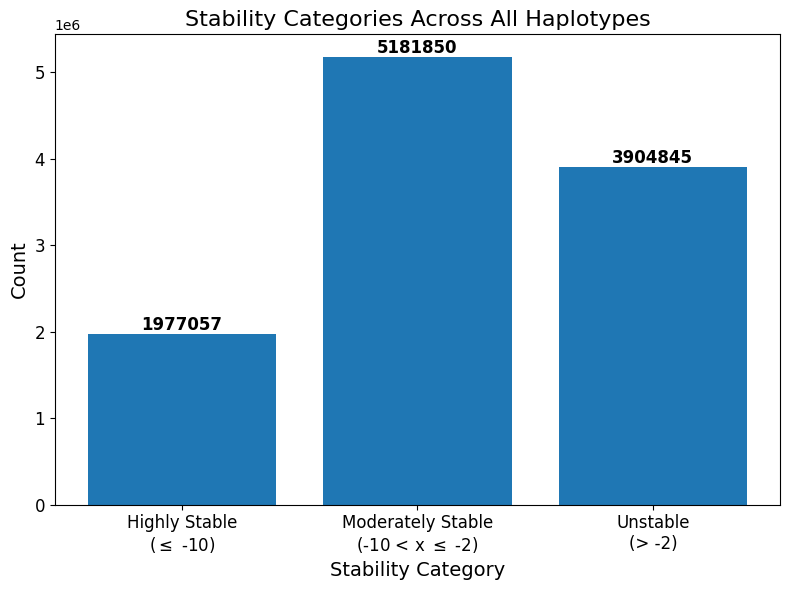

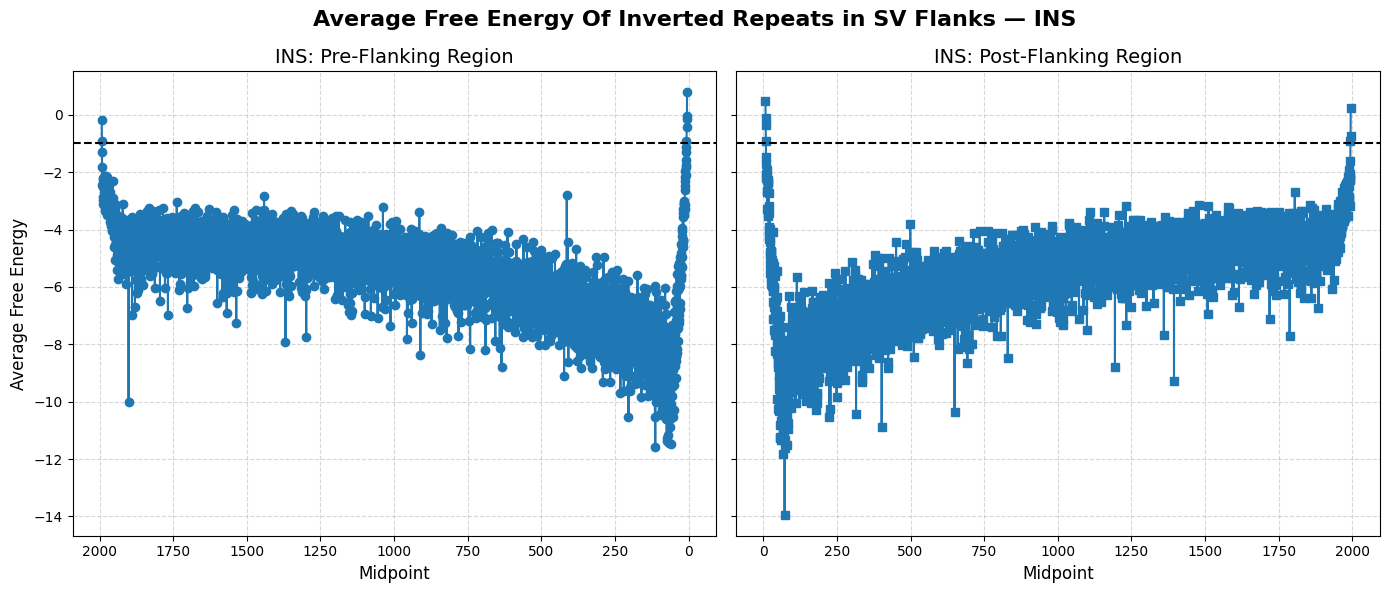

[OK] Saved: average_free_energy_pre_post_INS.pdf


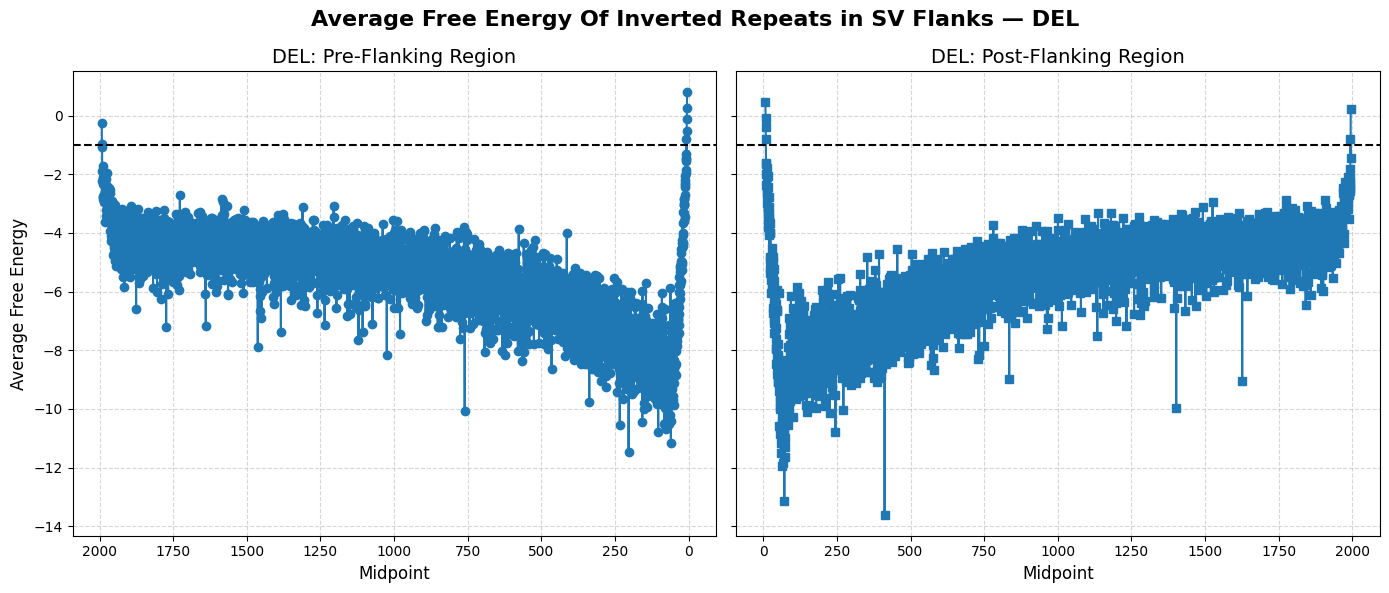

[OK] Saved: average_free_energy_pre_post_DEL.pdf


In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re

# Define the directory containing the TSV files
data_dir = "/home/alextu/scratch/free_energy_IRs_SVs/"

# Find all `.tsv` files in the directory
tsv_files = glob.glob(os.path.join(data_dir, "*NA*.tsv"))

# Load all TSV files into a single DataFrame
all_data = []
for file in tsv_files:
    df = pd.read_csv(file, sep="\t")
    df["Haplotype"] = os.path.basename(file).split("_hap")[0]  # Extract sample ID
    all_data.append(df)

# Merge all data
df = pd.concat(all_data, ignore_index=True)

# ------------------------------
# Step 1: Categorize Stability
# ------------------------------
def categorize_stability(value):
    if value <= -10:
        return "Highly Stable\n($\\leq$ -10)"
    elif value <= -2:
        return "Moderately Stable\n(-10 < x $\\leq$ -2)"
    else:
        return "Unstable\n(> -2)"

# Detect the correct Free Energy column name and use it consistently
if "Free_Energy" in df.columns:
    FREE_COL = "Free_Energy"
elif "Q" in df.columns:
    FREE_COL = "Q"
else:
    raise ValueError("Neither 'Free_Energy' nor 'Q' columns found in the dataset.")

df["Stability"] = df[FREE_COL].apply(categorize_stability)

# ------------------------------
# Step 2: Extract Flanking Region
# ------------------------------
def extract_flank(sequence_name):
    try:
        return sequence_name.split('|')[-1]
    except Exception:
        return "Unknown"

df["Flank"] = df["Sequence_name"].apply(extract_flank)

# ------------------------------
# Step 3: Compute Mid Position
# ------------------------------
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2
#df["Mid_Position"] = df["Stop"]

# ------------------------------
# NEW: Extract SV Type (INS/DEL)
# ------------------------------
def extract_svtype(s):
    # Try Sequence_name first
    txt = str(s)
    m = re.search(r'(?:^|[._|\-])(INS|DEL)(?:[._|\-]|$)', txt, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()
    return "Unknown"

# Prefer Sequence_name; if it's missing, fall back to filename token if present
if "Sequence_name" in df.columns:
    df["SVType"] = df["Sequence_name"].apply(extract_svtype)
else:
    df["SVType"] = "Unknown"

# Keep only rows with identified SV type and known flank
df = df[(df["SVType"].isin(["INS", "DEL"])) & (df["Flank"].isin(["pre_flank", "post_flank"]))]

# ------------------------------
# Step 4: Count Stability Categories Across All Haplotypes (UNCHANGED)
# ------------------------------
stability_categories = [
    "Highly Stable\n($\\leq$ -10)", 
    "Moderately Stable\n(-10 < x $\\leq$ -2)", 
    "Unstable\n(> -2)"
]

stability_counts = df["Stability"].value_counts().reindex(stability_categories).fillna(0)

# ------------------------------
# Step 5: Plot Stability Categories Across All Haplotypes (UNCHANGED)
# ------------------------------
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(stability_categories, stability_counts, color="#1f77b4")  # Blue

# Add count labels
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h, f'{int(h)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel("Stability Category", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Stability Categories Across All Haplotypes", fontsize=16)
ax.set_xticks(range(len(stability_categories)))
ax.set_xticklabels(stability_categories, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('stability_categories_all_haplotypes.pdf', format='pdf', dpi=300)
plt.show()

# ------------------------------
# Step 6: Compute Average Free Energy By Flanking Region & Mid_Position
# ------------------------------
avg_free_energy = (
    df.groupby(["Flank", "Mid_Position"])[FREE_COL]
      .mean()
      .reset_index()
      .rename(columns={FREE_COL: "Free_Energy_Avg"})
)

# ------------------------------
# Helper: Plot pre vs post for a given SV type (INS or DEL)
# ------------------------------
def plot_pre_post_for_svtype(df_all, svtype_label, out_pdf):
    sub = df_all[df_all["SVType"] == svtype_label]
    if sub.empty:
        print(f"[WARN] No rows for {svtype_label}; skipping {out_pdf}")
        return

    avg_fe = (
        sub.groupby(["Flank", "Mid_Position"])[FREE_COL]
           .mean()
           .reset_index()
           .rename(columns={FREE_COL: "Free_Energy_Avg"})
           .sort_values(["Flank", "Mid_Position"])
    )

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Pre-flank
    pre_flank = avg_fe[avg_fe["Flank"] == "pre_flank"]
    axs[0].plot(pre_flank["Mid_Position"], pre_flank["Free_Energy_Avg"], color='#1f77b4', marker='o')
    axs[0].axhline(y=-1, color='black', linestyle='--', linewidth=1.5)
    axs[0].set_title(f"{svtype_label}: Pre-Flanking Region", fontsize=14)
    axs[0].set_xlabel("Midpoint", fontsize=12)
    axs[0].set_ylabel("Average Free Energy", fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.5)
    # --- Fix x-axis ticks for pre-flank (display 2000→0 labels only) ---
    axs[0].set_xticks(range(0, 2001, 250))                  # tick positions
    axs[0].set_xticklabels([str(2000 - x) for x in range(0, 2001, 250)])  # flipped labels
    axs[0].tick_params(axis='x', labelrotation=0)

    # Post-flank
    post_flank = avg_fe[avg_fe["Flank"] == "post_flank"]
    axs[1].plot(post_flank["Mid_Position"], post_flank["Free_Energy_Avg"], color='#1f77b4', marker='s')
    axs[1].axhline(y=-1, color='black', linestyle='--', linewidth=1.5)
    axs[1].set_title(f"{svtype_label}: Post-Flanking Region", fontsize=14)
    axs[1].set_xlabel("Midpoint", fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.5)

    plt.suptitle(f"Average Free Energy Of Inverted Repeats in SV Flanks — {svtype_label}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(out_pdf, format='pdf', dpi=300)
    plt.show()
    print(f"[OK] Saved: {out_pdf}")

# ------------------------------
# Plot: INS (pre vs post)
# ------------------------------
plot_pre_post_for_svtype(df, "INS", "average_free_energy_pre_post_INS.pdf")

# ------------------------------
# Plot: DEL (pre vs post)
# ------------------------------
plot_pre_post_for_svtype(df, "DEL", "average_free_energy_pre_post_DEL.pdf")

Stability  Stable (<0)  Unstable (≥0)
SD                                   
in_SD         28515757        1088409
not_in_SD    316058943       12323902


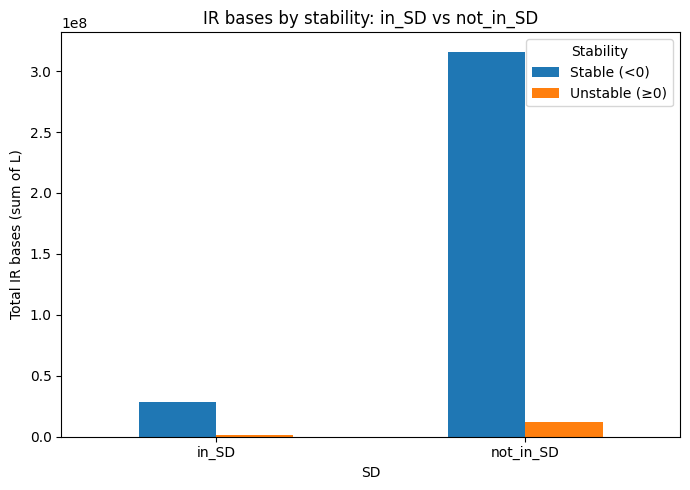

In [1]:
#!/usr/bin/env python3
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
DATA_DIR = "/home/alextu/scratch/free_energy_IRs_SVs_SDs/"
PATTERN  = "*NA*.tsv"
# ===============

# ---- Load & merge ----
tsv_files = glob.glob(os.path.join(DATA_DIR, PATTERN))
if not tsv_files:
    raise FileNotFoundError(f"No files matched {os.path.join(DATA_DIR, PATTERN)}")

dfs = []
for fp in tsv_files:
    d = pd.read_csv(fp, sep="\t")
    d["SourceFile"] = os.path.basename(fp)
    dfs.append(d)
df = pd.concat(dfs, ignore_index=True)

# ---- Length (L) ----
if "Length" in df.columns:
    df["L"] = pd.to_numeric(df["Length"], errors="coerce")
else:
    df["L"] = (pd.to_numeric(df.get("Stop", np.nan), errors="coerce")
               - pd.to_numeric(df.get("Start", np.nan), errors="coerce"))

# ---- Stability score column ----
FREE_COL = "Free_Energy" if "Free_Energy" in df.columns else ("Q" if "Q" in df.columns else None)
if FREE_COL is None:
    raise ValueError("Need 'Free_Energy' or 'Q' in input files.")
df[FREE_COL] = pd.to_numeric(df[FREE_COL], errors="coerce")

# ---- Normalize SD labels ----
def norm_sd(x):
    s = str(x).strip().lower()
    if s == "in_sd": return "in_SD"
    if s == "not_in_sd": return "not_in_SD"
    return None

df["SD"] = df["SD"].map(norm_sd)

# ---- Filter usable rows ----
df = df.dropna(subset=["L", FREE_COL, "SD"]).copy()
df = df[df["SD"].isin(["in_SD","not_in_SD"])]

# ---- Stability buckets: IR Stable if <0, Unstable if ≥0 ----
df["Stability"] = np.where(df[FREE_COL] < 0, "Stable (<0)", "Unstable (≥0)")

# ---- Sum of IR bases by SD × Stability ----
base_counts = (df.groupby(["SD","Stability"])["L"]
                 .sum()
                 .unstack(fill_value=0)
                 .loc[["in_SD","not_in_SD"]])  # enforce order

print(base_counts)

# ---- Plot ----
ax = base_counts.plot(kind="bar", figsize=(7,5))
ax.set_ylabel("Total IR bases (sum of L)")
ax.set_title("IR bases by stability: in_SD vs not_in_SD")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

IR density (bp/kb): in_SD = 183.57151197082226 not_in_SD = 210.46158434528687
Fisher odds ratio: 0.8435048130139327 p-value: 0.0


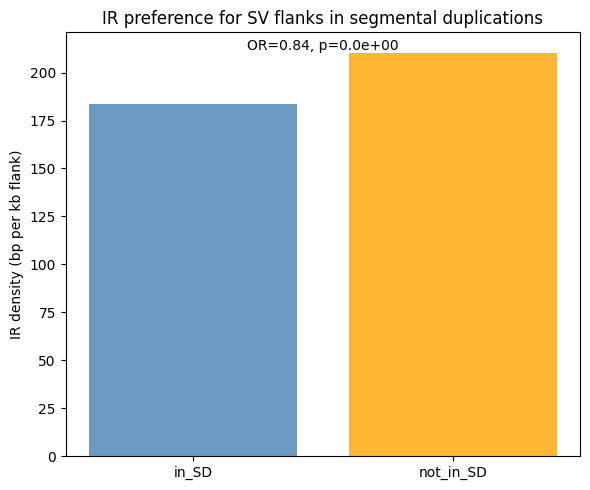

In [2]:
#!/usr/bin/env python3
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

# ================= CONFIG =================
DATA_DIR  = "/home/alextu/scratch/free_energy_IRs_SVs_SDs/"
PATTERN   = "*NA*.tsv"
FLANK_LEN = 2000   # bp per flank window
# ==========================================

# ---- Load ----
tsv_files = glob.glob(os.path.join(DATA_DIR, PATTERN))
if not tsv_files:
    raise FileNotFoundError(f"No files matched in {DATA_DIR}")

dfs = []
for fp in tsv_files:
    d = pd.read_csv(fp, sep="\t")
    d["SourceFile"] = os.path.basename(fp)
    if "Sequence_name" in d.columns:
        d["Sample"] = d["Sequence_name"]
    else:
        d["Sample"] = d["SourceFile"]
    dfs.append(d)
df = pd.concat(dfs, ignore_index=True)

# ---- Length (L) ----
if "Length" in df.columns:
    df["L"] = pd.to_numeric(df["Length"], errors="coerce")
else:
    df["L"] = (pd.to_numeric(df.get("Stop", np.nan), errors="coerce")
               - pd.to_numeric(df.get("Start", np.nan), errors="coerce"))

# ---- Normalize SD ----
def norm_sd(x):
    s = str(x).strip().lower()
    if s == "in_sd": return "in_SD"
    if s == "not_in_sd": return "not_in_SD"
    return None

df["SD_norm"] = df["SD"].map(norm_sd)

# ---- Keep usable ----
df = df.dropna(subset=["L","SD_norm","Sample"]).copy()
df = df[df["SD_norm"].isin(["in_SD","not_in_SD"])]

# ----- Denominators -----
flanks = df.groupby("Sample", as_index=False).agg(SD_norm=("SD_norm","first"))
n_flanks = flanks["SD_norm"].value_counts().to_dict()
n_in  = int(n_flanks.get("in_SD", 0))
n_out = int(n_flanks.get("not_in_SD", 0))
tot_bp_in, tot_bp_out = n_in*FLANK_LEN, n_out*FLANK_LEN

# ----- Numerators -----
ir_bp = df.groupby("SD_norm")["L"].sum().to_dict()
ir_bp_in  = float(ir_bp.get("in_SD", 0.0))
ir_bp_out = float(ir_bp.get("not_in_SD", 0.0))
non_ir_bp_in  = max(tot_bp_in  - ir_bp_in,  0.0)
non_ir_bp_out = max(tot_bp_out - ir_bp_out, 0.0)

# ----- Fisher’s test -----
table = [[ir_bp_in, ir_bp_out],
         [non_ir_bp_in, non_ir_bp_out]]
oddsratio, pvalue = fisher_exact(table)

# ----- Densities -----
dens_in  = (ir_bp_in  / tot_bp_in)  * 1000 if tot_bp_in  > 0 else float("nan")
dens_out = (ir_bp_out / tot_bp_out) * 1000 if tot_bp_out > 0 else float("nan")

print("IR density (bp/kb): in_SD =", dens_in, "not_in_SD =", dens_out)
print("Fisher odds ratio:", oddsratio, "p-value:", pvalue)

# ====== PLOT ======
plt.figure(figsize=(6,5))
plt.bar(["in_SD","not_in_SD"], [dens_in, dens_out],
        color=["steelblue","orange"], alpha=0.8)

plt.ylabel("IR density (bp per kb flank)")
plt.title("IR preference for SV flanks in segmental duplications")

# Annotate Fisher’s test result
plt.text(0.5, max(dens_in,dens_out)*1.0,
         f"OR={oddsratio:.2f}, p={pvalue:.1e}",
         ha="center", va="bottom", fontsize=10, color="black")

plt.tight_layout()
plt.show()

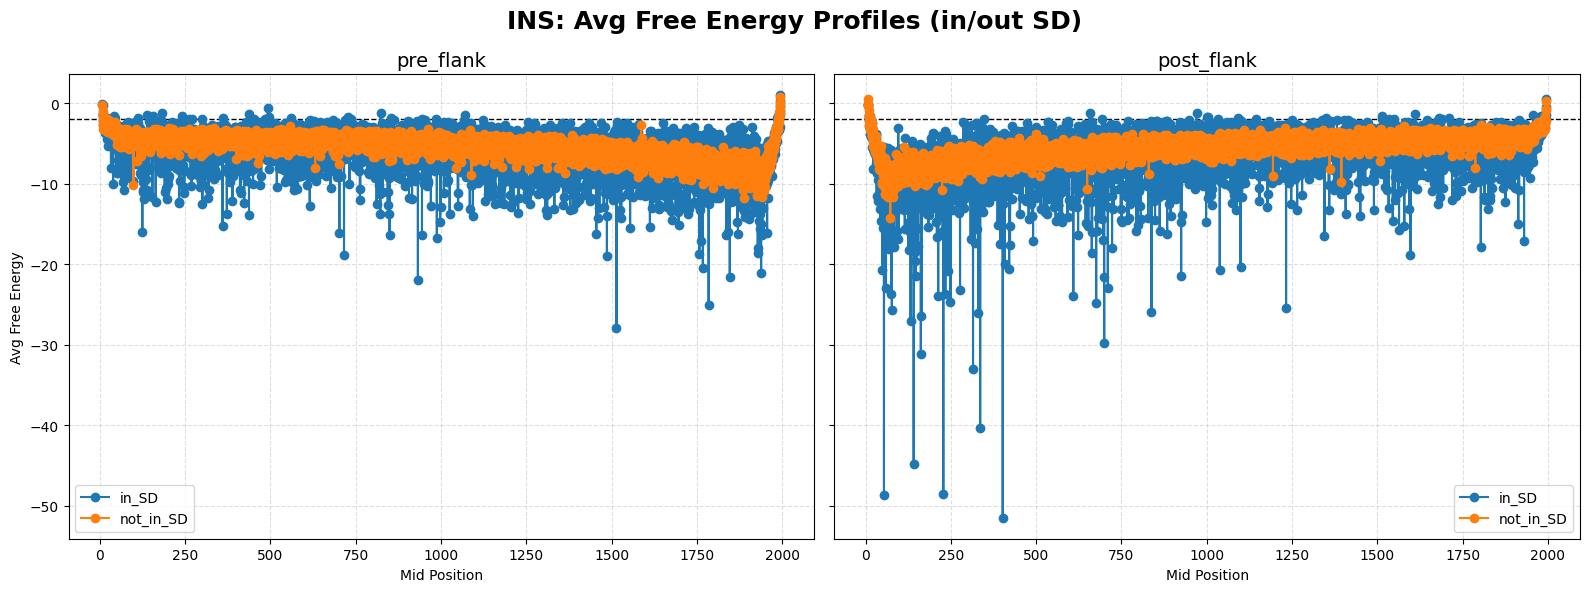

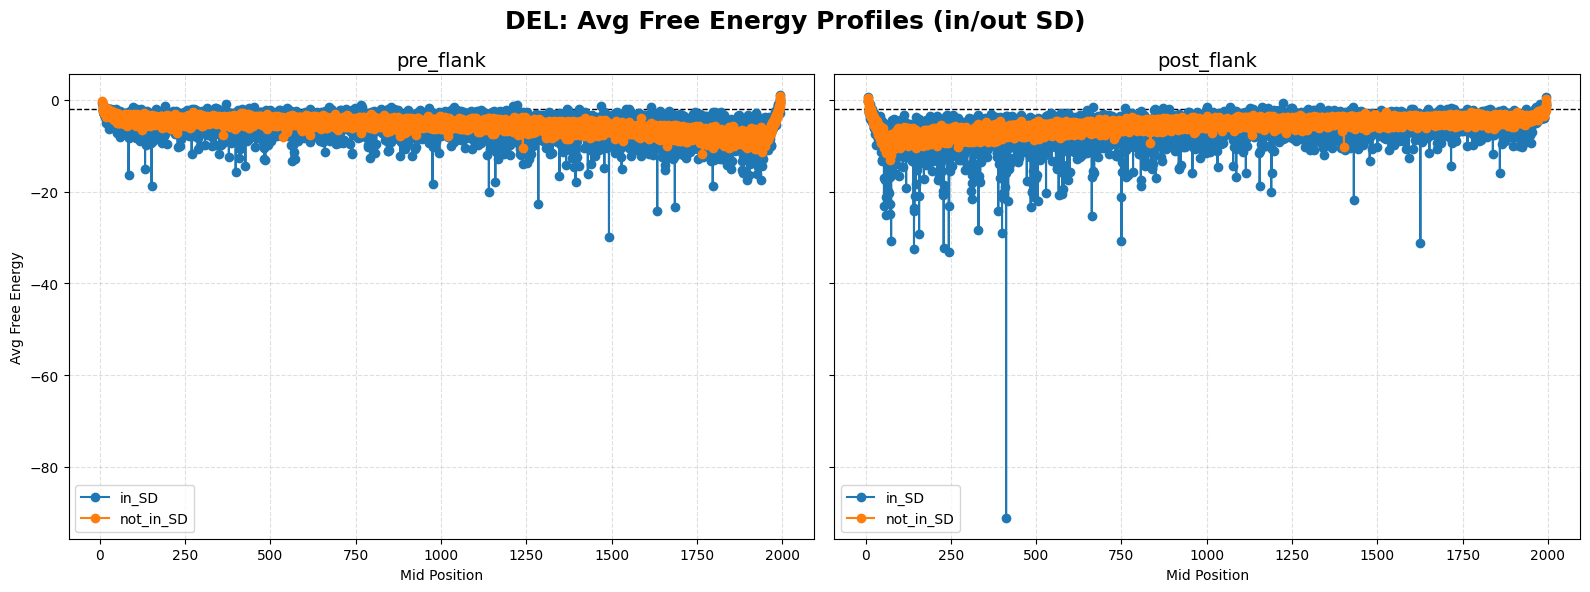

In [1]:
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Step 0: Load and merge IR files (already SD-annotated)
# ------------------------------
data_dir = "/home/alextu/scratch/free_energy_IRs_SVs_SDs/"
tsv_files = glob.glob(os.path.join(data_dir, "*NA*.tsv"))

all_data = []
for file in tsv_files:
    df = pd.read_csv(file, sep="\t")
    df["Haplotype"] = os.path.basename(file).split("_hap")[0]
    all_data.append(df)

df = pd.concat(all_data, ignore_index=True)

# ------------------------------
# Step 1: Categorize Stability
# ------------------------------
def categorize_stability(value):
    if value <= -10:
        return "Highly Stable\n($\\leq$ -10)"
    elif value <= -2:
        return "Moderately Stable\n(-10 < x $\\leq$ -2)"
    else:
        return "Unstable\n(> -2)"

FREE_COL = "Free_Energy" if "Free_Energy" in df.columns else "Q"
df["Stability"] = df[FREE_COL].apply(categorize_stability)

# ------------------------------
# Step 2: Extract Flanking Region and SV type
# ------------------------------
df["Flank"] = df["Sequence_name"].str.split("|").str[-1]

def extract_svtype(s):
    m = re.search(r'(?:^|[._|\-])(INS|DEL)(?:[._|\-]|$)', str(s), flags=re.IGNORECASE)
    return m.group(1).upper() if m else "Unknown"

df["SVType"] = df["Sequence_name"].apply(extract_svtype)

# ------------------------------
# Step 3: Mid position
# ------------------------------
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2

# Keep only usable rows
df = df[df["SVType"].isin(["INS","DEL"]) & df["Flank"].isin(["pre_flank","post_flank"])]
df = df[df["SD"].isin(["in_SD","not_in_SD"])]  # use your annotated SD column

# ------------------------------
# Plot B: Free energy profiles (INS vs DEL, split by SD)
# ------------------------------
def plot_profiles_for_svtype(df_all, svtype_label):
    sub = df_all[df_all["SVType"]==svtype_label]
    if sub.empty:
        print(f"No data for {svtype_label}")
        return
    
    prof = (sub.groupby(["Flank","SD","Mid_Position"], as_index=False)[FREE_COL]
                 .mean().rename(columns={FREE_COL:"Free_Energy_Avg"}))
    
    fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)
    fig.suptitle(f"{svtype_label}: Avg Free Energy Profiles (in/out SD)", fontsize=18, fontweight="bold")
    
    for i, flank in enumerate(["pre_flank","post_flank"]):
        ax = axs[i]
        ax.set_title(flank, fontsize=14)
        ax.set_xlabel("Mid Position")
        if i==0:
            ax.set_ylabel("Avg Free Energy")
        ax.axhline(y=-2, color="black", linestyle="--", linewidth=1)
        for sd, sub2 in prof[prof["Flank"]==flank].groupby("SD"):
            ax.plot(sub2["Mid_Position"], sub2["Free_Energy_Avg"], marker="o", label=sd)
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.4)
    
    plt.tight_layout()
    plt.show()

plot_profiles_for_svtype(df, "INS")
plot_profiles_for_svtype(df, "DEL")

/tmp/ipykernel_2722221/2581043275.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = df.groupby(["SVType", "Flank", "SD", "Bin"]).size().reset_index(name="n")


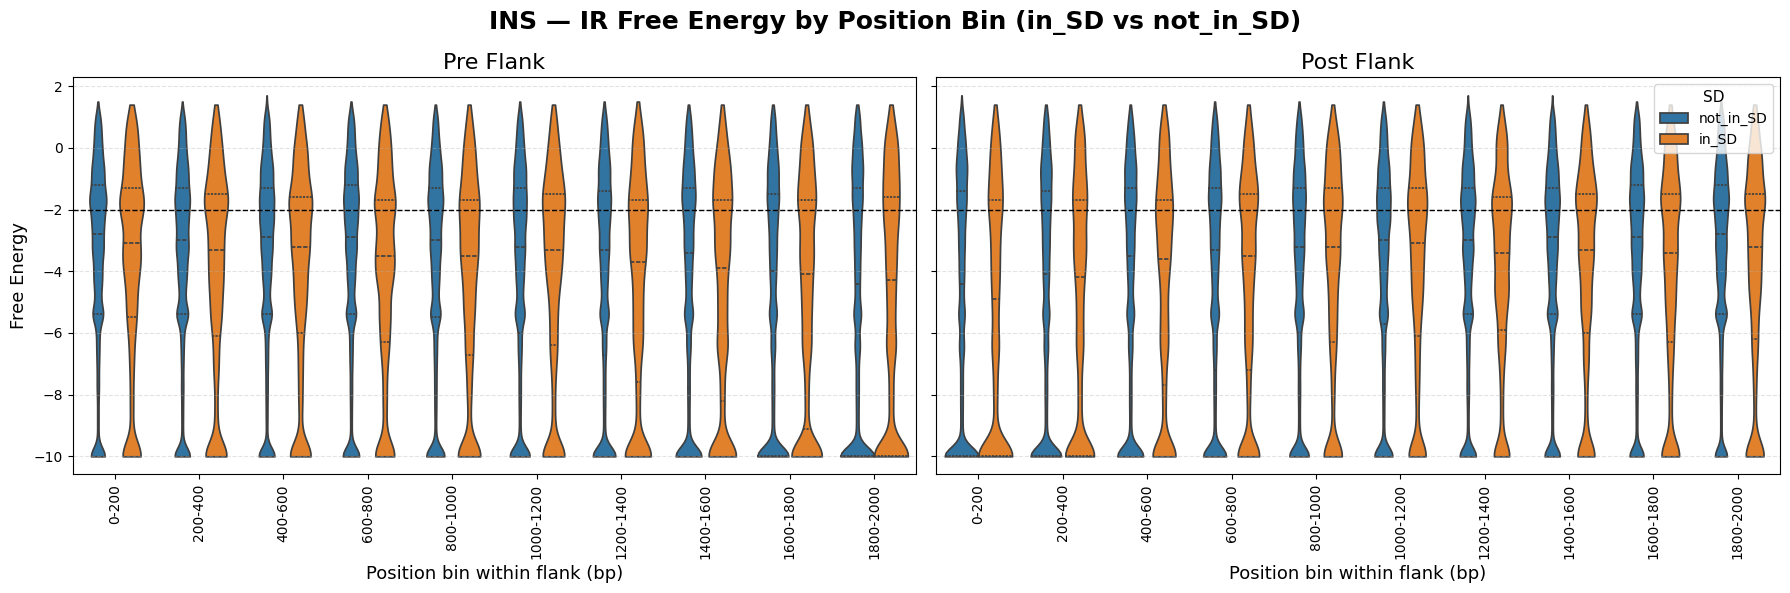

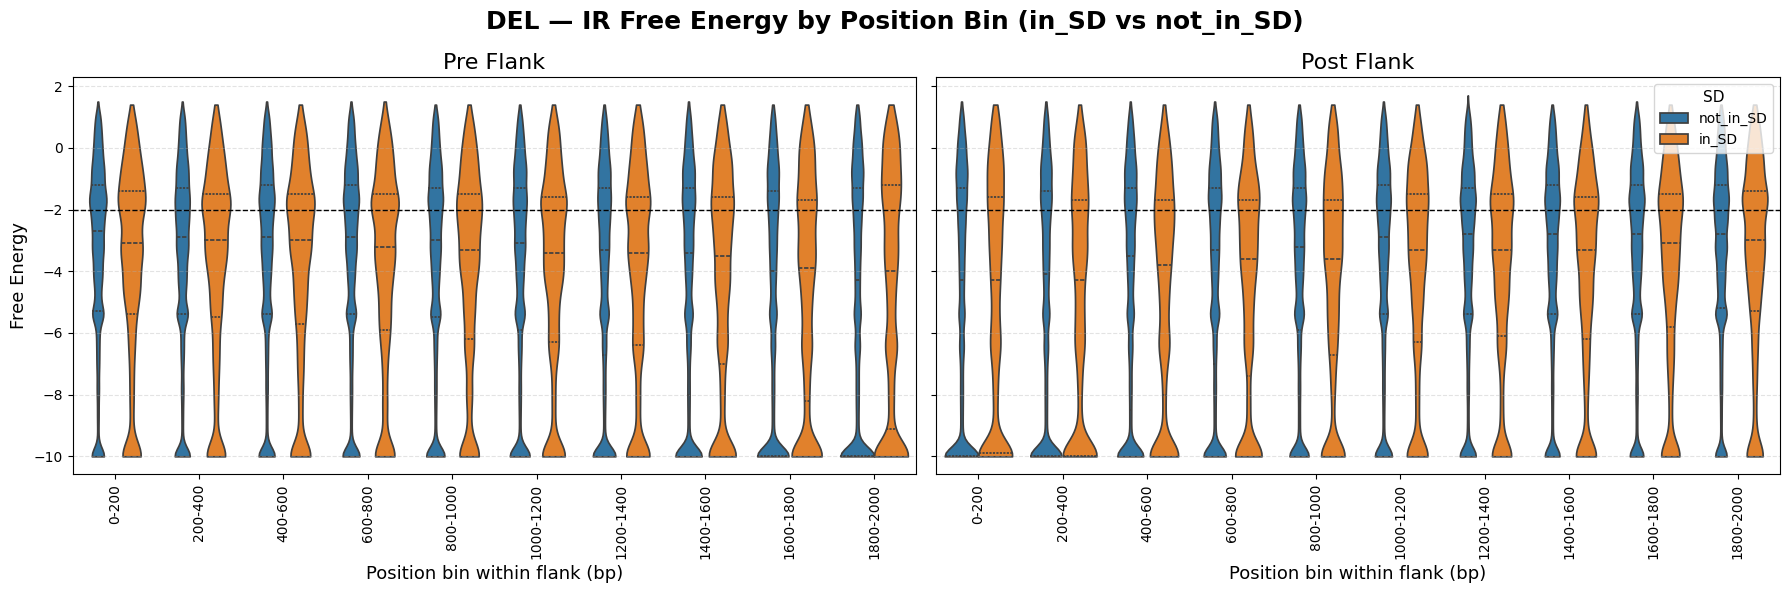

In [5]:
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===================== CONFIG =====================
data_dir    = "/home/alextu/scratch/free_energy_IRs_SVs_SDs/"
pattern     = "*NA*.tsv"
FLANKS      = ["pre_flank", "post_flank"]
SVTYPES     = ["INS", "DEL"]
SD_LEVELS   = ["in_SD", "not_in_SD"]

FLANK_LEN   = 2000     # bp window (0..2000)
BIN_SIZE    = 200      # bp per bin for violins
MIN_PER_BIN = 10       # drop bin×SD cells with < N obs
FE_GUIDE    = -2.0     # dashed guide line on plots
FE_FLOOR    = -10.0    # cap floor
# ===================================================

# ---------- Load & merge IR files ----------
tsv_files = glob.glob(os.path.join(data_dir, pattern))
if not tsv_files:
    raise FileNotFoundError(f"No TSVs found under {data_dir} matching {pattern}")

dfs = []
for fp in tsv_files:
    d = pd.read_csv(fp, sep="\t")
    d["Haplotype"] = os.path.basename(fp).split("_hap")[0]
    dfs.append(d)

df = pd.concat(dfs, ignore_index=True)

# ---------- Column detection ----------
FREE_COL = "Free_Energy" if "Free_Energy" in df.columns else ("Q" if "Q" in df.columns else None)
if FREE_COL is None:
    raise ValueError("Neither 'Free_Energy' nor 'Q' found in input files; cannot plot free energy.")

# ---------- Cap Free Energy at -10 (floor) ----------
df[FREE_COL] = df[FREE_COL].clip(lower=FE_FLOOR)

# ---------- Derive flanks / SV types / mid position ----------
df["Flank"] = df["Sequence_name"].astype(str).str.split("|").str[-1]

def extract_svtype(s):
    m = re.search(r'(?:^|[._|\-])(INS|DEL)(?:[._|\-]|$)', str(s), flags=re.IGNORECASE)
    return m.group(1).upper() if m else "Unknown"

df["SVType"] = df["Sequence_name"].apply(extract_svtype)
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2.0

# Keep usable rows
df = df[df["SVType"].isin(SVTYPES) & df["Flank"].isin(FLANKS)]
df = df[df["SD"].isin(SD_LEVELS)].copy()

# ---------- Clip to window and bin positions ----------
df["Mid_Position"] = df["Mid_Position"].clip(lower=0, upper=FLANK_LEN - 1e-6)

bin_edges  = np.arange(0, FLANK_LEN + BIN_SIZE, BIN_SIZE)
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges) - 1)]
df["Bin"]  = pd.cut(df["Mid_Position"], bins=bin_edges, right=False, labels=bin_labels)
df["Bin"]  = pd.Categorical(df["Bin"], categories=bin_labels, ordered=True)

# ---------- Optional: drop sparse bins ----------
cell_counts = df.groupby(["SVType", "Flank", "SD", "Bin"]).size().reset_index(name="n")
valid_cells = cell_counts[cell_counts["n"] >= MIN_PER_BIN][["SVType", "Flank", "SD", "Bin"]]
df_v = df.merge(valid_cells, on=["SVType", "Flank", "SD", "Bin"], how="inner")

# ---------- Plotting helper ----------
def violin_by_bins(df_in, svtype_label):
    sub = df_in[df_in["SVType"] == svtype_label].copy()
    if sub.empty:
        print(f"[WARN] No data for {svtype_label}; skipping.")
        return

    fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
    fig.suptitle(f"{svtype_label} — IR Free Energy by Position Bin (in_SD vs not_in_SD)",
                 fontsize=18, fontweight="bold")

    for i, flank in enumerate(FLANKS):
        ax = axs[i]
        pane = sub[sub["Flank"] == flank]
        if pane.empty:
            ax.set_visible(False)
            continue

        sns.violinplot(
            data=pane, x="Bin", y=FREE_COL, hue="SD",
            dodge=True, cut=0, inner="quartile", ax=ax
        )

        ax.axhline(y=FE_GUIDE, color="black", linestyle="--", linewidth=1)
        ax.set_title(flank.replace("_", " ").title(), fontsize=16)
        ax.set_xlabel("Position bin within flank (bp)", fontsize=13)
        if i == 0:
            ax.set_ylabel("Free Energy", fontsize=13)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis="x", labelrotation=90)
        ax.grid(True, axis="y", linestyle="--", alpha=0.35)

        if i == 1:
            ax.legend(title="SD", fontsize=10, title_fontsize=11)
        else:
            leg = ax.legend_
            if leg is not None:
                leg.remove()

    plt.tight_layout()
    plt.show()

# ---------- Make the plots ----------
violin_by_bins(df_v, "INS")
violin_by_bins(df_v, "DEL")

/tmp/ipykernel_3162680/2903417188.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(downsample_not_in_sd)
/tmp/ipykernel_3162680/2903417188.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = df_bal.groupby(["SVType","Flank","SD","Bin"]).size().reset_index(name="n")


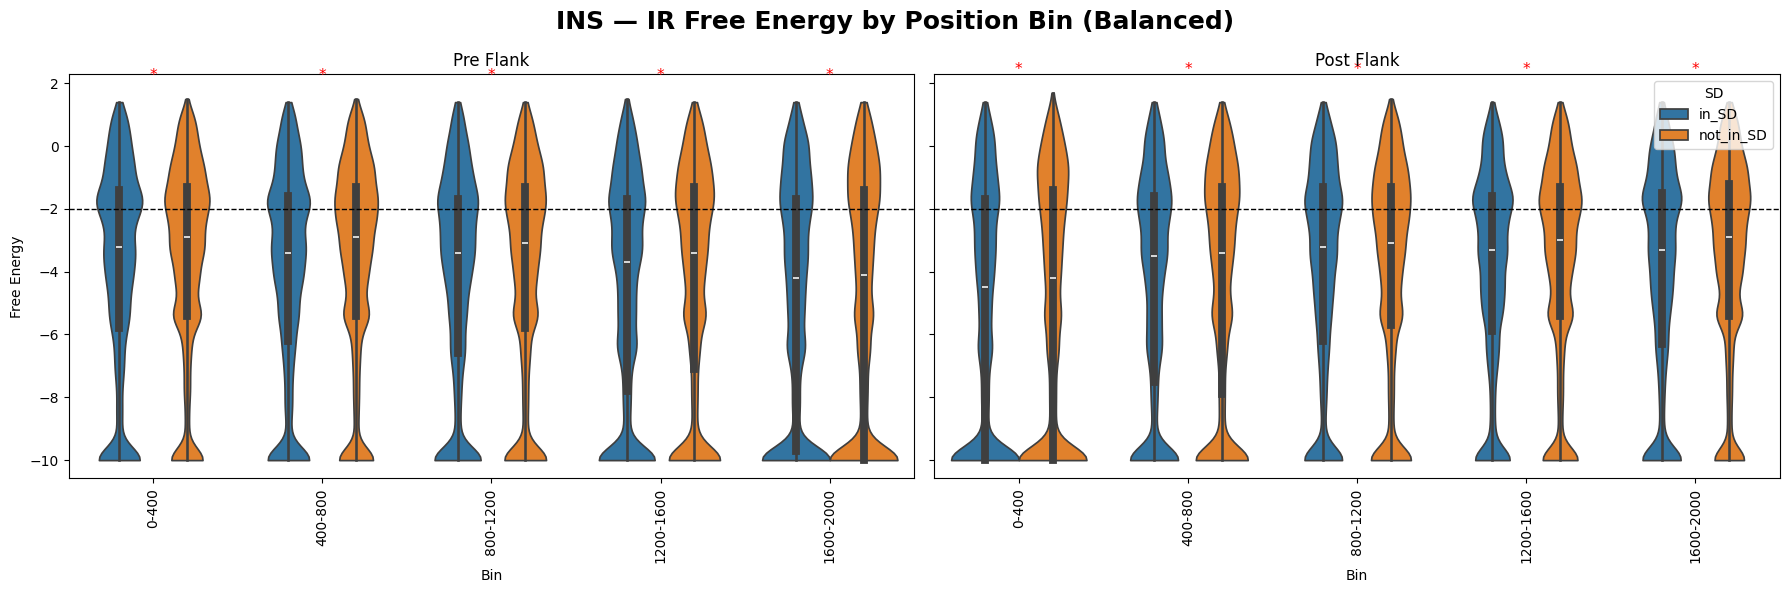

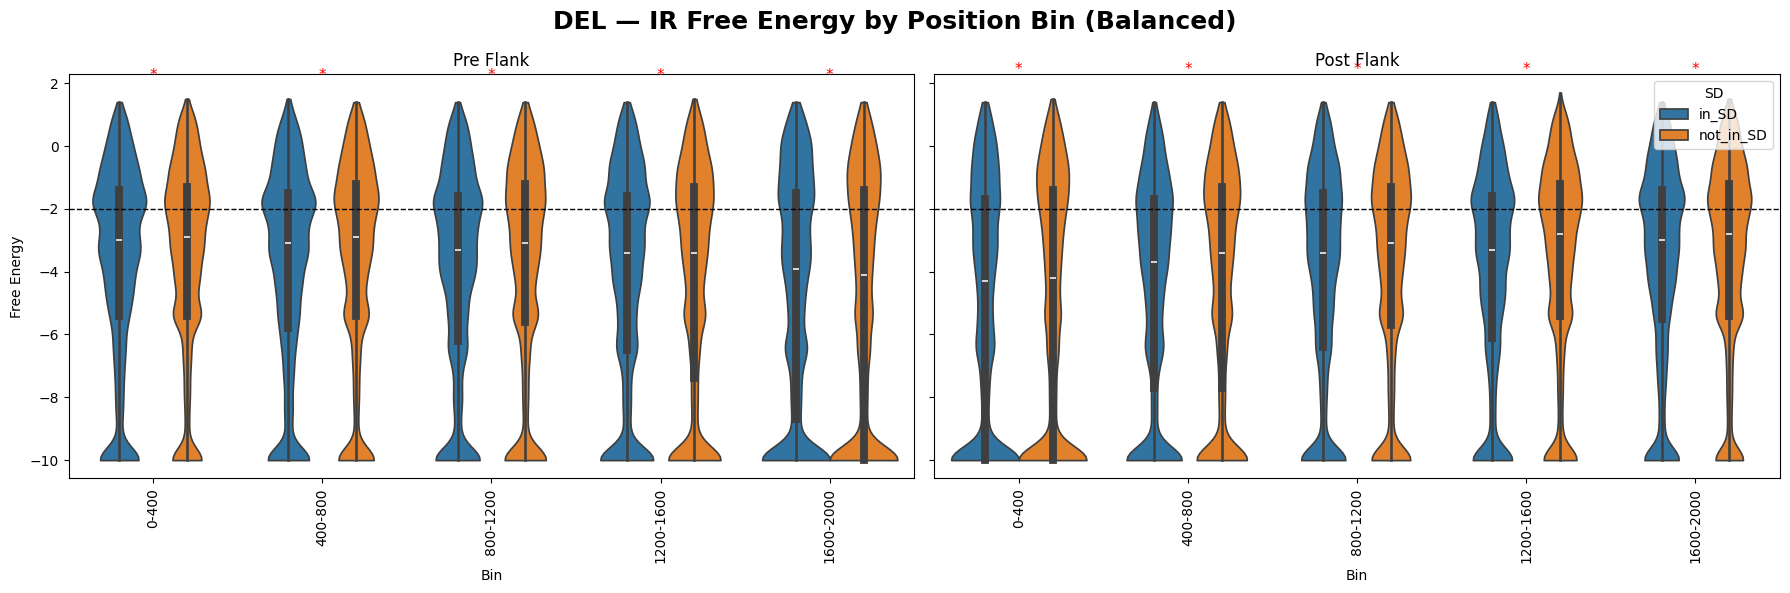

In [4]:
#!/usr/bin/env python3
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# ===================== CONFIG =====================
data_dir    = "/home/alextu/scratch/free_energy_IRs_SVs_SDs/"
pattern     = "*NA*.tsv"
FLANKS      = ["pre_flank", "post_flank"]
SVTYPES     = ["INS", "DEL"]
SD_LEVELS   = ["in_SD", "not_in_SD"]

FLANK_LEN   = 2000   # bp window (0..2000)
BIN_SIZE    = 400    # bp per bin for violins
MIN_PER_BIN = 10     # drop bin×SD cells with < N obs
MIN_PER_GRP = 5      # require at least this many points per SD group per bin for stats
FE_GUIDE    = -2.0   # dashed guide line
FE_FLOOR    = -10.0  # clip floor for stability values
RNG_SEED    = 42     # reproducible downsampling
# ===================================================

# ---------- Load ----------
tsv_files = glob.glob(os.path.join(data_dir, pattern))
if not tsv_files:
    raise FileNotFoundError(f"No TSVs found under {data_dir} matching {pattern}")

dfs = []
for fp in tsv_files:
    d = pd.read_csv(fp, sep="\t")
    dfs.append(d)
df = pd.concat(dfs, ignore_index=True)

# ---------- Columns ----------
FREE_COL = "Free_Energy" if "Free_Energy" in df.columns else ("Q" if "Q" in df.columns else None)
if FREE_COL is None:
    raise ValueError("Neither 'Free_Energy' nor 'Q' found in input files.")

df[FREE_COL] = pd.to_numeric(df[FREE_COL], errors="coerce").clip(lower=FE_FLOOR)

df["Flank"] = df["Sequence_name"].astype(str).str.split("|").str[-1]

def extract_svtype(s):
    m = re.search(r'(?:^|[._|\-])(INS|DEL)(?:[._|\-]|$)', str(s), flags=re.IGNORECASE)
    return m.group(1).upper() if m else "Unknown"

df["SVType"] = df["Sequence_name"].apply(extract_svtype)
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2.0

# Keep usable rows
df = df[df["SVType"].isin(SVTYPES) & df["Flank"].isin(FLANKS)]
df = df[df["SD"].isin(SD_LEVELS)].copy()

# ---------- Binning ----------
df["Mid_Position"] = df["Mid_Position"].clip(0, FLANK_LEN-1e-6)
bin_edges  = np.arange(0, FLANK_LEN + BIN_SIZE, BIN_SIZE)
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]
df["Bin"]  = pd.cut(df["Mid_Position"], bins=bin_edges, right=False, labels=bin_labels)
df["Bin"]  = pd.Categorical(df["Bin"], categories=bin_labels, ordered=True)

# ---------- Balance not_in_SD by downsampling ----------
def downsample_not_in_sd(cell_df: pd.DataFrame) -> pd.DataFrame:
    a = cell_df[cell_df["SD"] == "in_SD"]
    b = cell_df[cell_df["SD"] == "not_in_SD"]
    if a.empty or b.empty: 
        return cell_df
    k = len(a)
    if len(b) <= k: 
        return pd.concat([a,b], ignore_index=True)
    b_s = b.sample(n=k, replace=False, random_state=RNG_SEED)
    return pd.concat([a, b_s], ignore_index=True)

df_bal = (
    df.groupby(["SVType","Flank","Bin"], observed=False, group_keys=False)
      .apply(downsample_not_in_sd)
      .reset_index(drop=True)
)

# ---------- Drop sparse bins ----------
cell_counts = df_bal.groupby(["SVType","Flank","SD","Bin"]).size().reset_index(name="n")
valid_cells = cell_counts[cell_counts["n"]>=MIN_PER_BIN][["SVType","Flank","SD","Bin"]]
df_v = df_bal.merge(valid_cells, on=["SVType","Flank","SD","Bin"], how="inner")

# ---------- Stats per bin ----------
records = []
for sv in SVTYPES:
    for flank in FLANKS:
        sub = df_bal[(df_bal["SVType"]==sv)&(df_bal["Flank"]==flank)]
        for b in bin_labels:
            pane = sub[sub["Bin"]==b]
            a = pane[pane["SD"]=="in_SD"][FREE_COL].dropna()
            b_ = pane[pane["SD"]=="not_in_SD"][FREE_COL].dropna()
            n1,n2 = len(a),len(b_)
            if n1>=MIN_PER_GRP and n2>=MIN_PER_GRP:
                u,p = mannwhitneyu(a,b_,alternative="two-sided")
            else:
                u,p = np.nan,np.nan
            records.append({
                "SVType":sv,"Flank":flank,"Bin":b,
                "n_in_SD":n1,"n_not_in_SD":n2,
                "median_in_SD":a.median() if n1 else np.nan,
                "median_not_in_SD":b_.median() if n2 else np.nan,
                "U":u,"p_value":p
            })

stats_df = pd.DataFrame.from_records(records)

# ---------- Benjamini–Hochberg FDR ----------
def bh_fdr(pvals):
    p = np.array(pvals,dtype=float)
    mask = ~np.isnan(p)
    m = mask.sum()
    out = np.full_like(p,np.nan,dtype=float)
    if m==0: return out
    ranks = np.argsort(np.where(mask,p,np.inf))
    cummin = np.inf
    k=0
    for i,idx in enumerate(ranks, start=1):
        if not mask[idx]: continue
        k+=1
        val = p[idx]*m/k
        cummin = min(cummin,val)
        out[idx]=min(cummin,1.0)
    return out

if not stats_df.empty:
    stats_df["p_value_adj"] = (
        stats_df.groupby(["SVType","Flank"],observed=False,group_keys=False)["p_value"]
                .transform(lambda s: bh_fdr(s.values))
    )

# ---------- Plot helper ----------
def violin_by_bins(df_in, svtype_label, stats_df):
    sub = df_in[df_in["SVType"]==svtype_label].copy()
    stats_sub = stats_df[stats_df["SVType"]==svtype_label]
    fig,axs = plt.subplots(1,2,figsize=(18,6),sharey=True)
    fig.suptitle(f"{svtype_label} — IR Free Energy by Position Bin (Balanced)",fontsize=18,fontweight="bold")

    for i,flank in enumerate(FLANKS):
        ax=axs[i]
        pane=sub[sub["Flank"]==flank]
        if pane.empty:
            ax.set_visible(False)
            continue
        sns.violinplot(data=pane,x="Bin",y=FREE_COL,hue="SD",
                       dodge=True,cut=0,inner="box",ax=ax)
        ax.axhline(y=FE_GUIDE,color="black",linestyle="--",linewidth=1)
        ax.set_title(flank.replace("_"," ").title())
        ax.tick_params(axis="x",labelrotation=90)
        if i==0: ax.set_ylabel("Free Energy")
        else: ax.set_ylabel("")

        flank_stats = stats_sub[stats_sub["Flank"]==flank]
        y_max=pane[FREE_COL].max() if not pane.empty else 0
        y_annot=y_max+0.5
        for j,bin_label in enumerate(df["Bin"].cat.categories):
            stat_row=flank_stats[flank_stats["Bin"]==bin_label]
            if stat_row.empty: continue
            p_adj=stat_row["p_value_adj"].values[0]
            star="*" if (p_adj<0.05) else "ns"
            ax.text(j,y_annot,star,ha="center",va="bottom",fontsize=11,color="red")

        if i==1: ax.legend(title="SD")
        else:
            leg=ax.get_legend()
            if leg is not None: leg.remove()

    plt.tight_layout()
    plt.show()

# ---------- Run ----------
violin_by_bins(df_v,"INS",stats_df)
violin_by_bins(df_v,"DEL",stats_df)

Dataset loaded successfully.


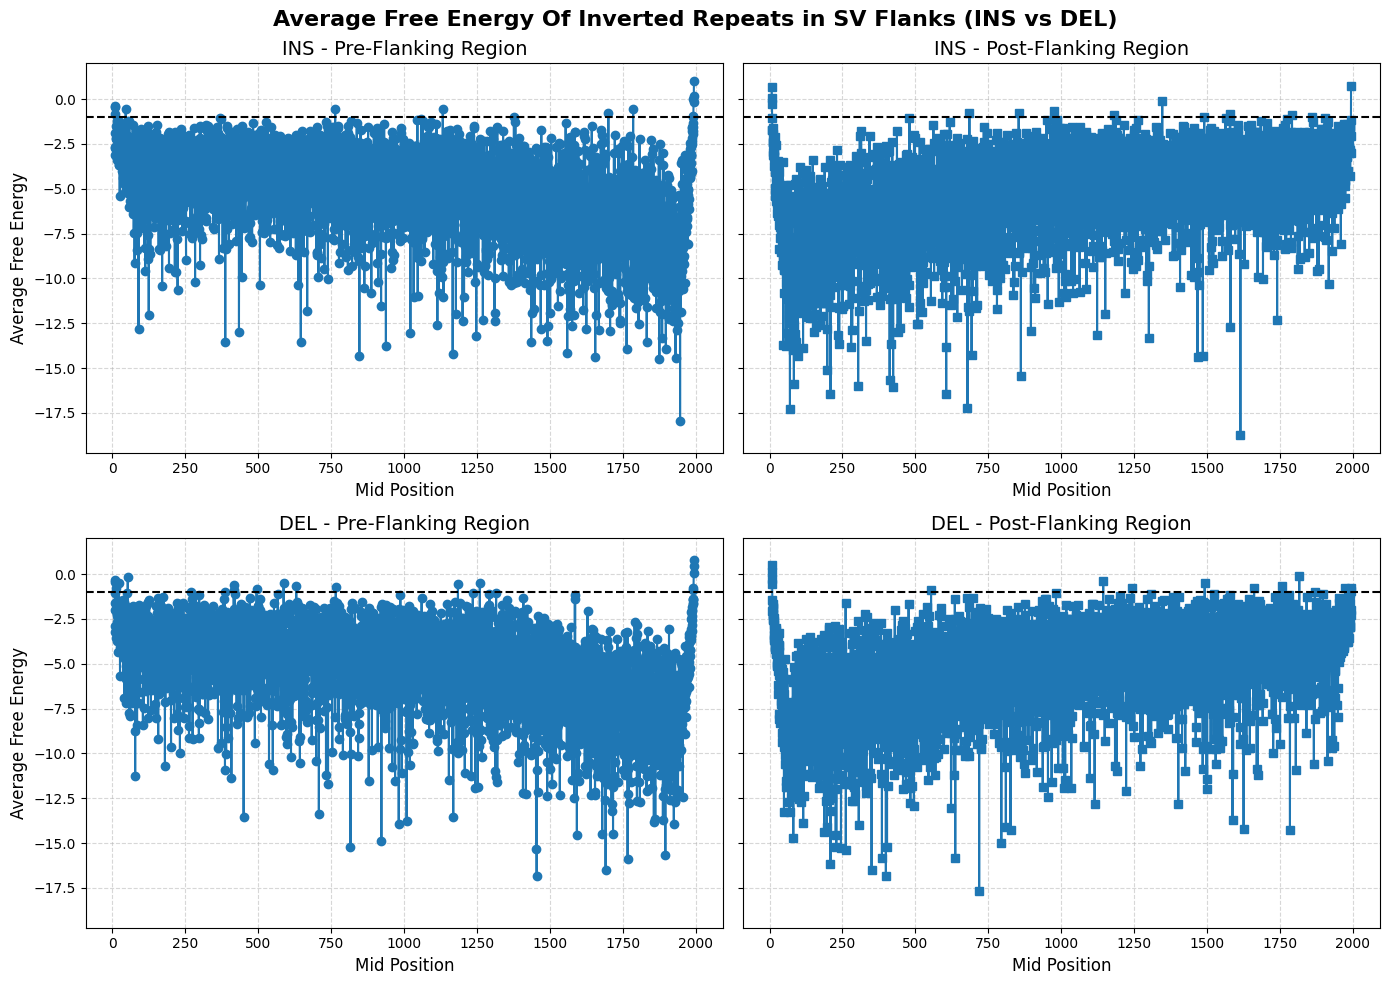

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file path (Modify this to the specific file you want to analyze)
file_path = "/home/alextu/scratch/free_energy_IRs_SVs/flanking_sequences_NA12329_hap2_IR_free_energy.tsv"

# Load the dataset
try:
    df = pd.read_csv(file_path, sep="\t")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    exit(1)
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty.")
    exit(1)
except pd.errors.ParserError:
    print(f"Error: The file '{file_path}' is malformed or not in TSV format.")
    exit(1)

# ------------------------------
# **Step 1: Extract Structural Variant Type (INS/DEL)**
# ------------------------------
def extract_sv_type(sequence_name):
    if "_INS" in sequence_name:
        return "INS"
    elif "_DEL" in sequence_name:
        return "DEL"
    else:
        return "Unknown"

df["SV_Type"] = df["Sequence_name"].apply(extract_sv_type)

# Keep only INS and DEL entries (ignore "Unknown")
df = df[df["SV_Type"].isin(["INS", "DEL"])]

# ------------------------------
# **Step 2: Extract Flanking Region**
# ------------------------------
def extract_flank(sequence_name):
    return sequence_name.split('|')[-1] if '|' in sequence_name else "Unknown"

df["Flank"] = df["Sequence_name"].apply(extract_flank)

# ------------------------------
# **Step 3: Compute Mid Position**
# ------------------------------
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2

# ------------------------------
# **Step 4: Compute Average Free Energy By Flank, Mid_Position, and SV Type**
# ------------------------------
avg_free_energy = df.groupby(["SV_Type", "Flank", "Mid_Position"])["Free_Energy"].mean().reset_index()

# ------------------------------
# **Step 5: Plot Aggregated Free Energy Trends (INS vs DEL)**
# ------------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# -------------------
# Subplot 1: INS - Pre-Flank
# -------------------
pre_flank_ins = avg_free_energy[(avg_free_energy["SV_Type"] == "INS") & (avg_free_energy["Flank"] == "pre_flank")]
axs[0, 0].plot(pre_flank_ins["Mid_Position"], pre_flank_ins["Free_Energy"], color='#1f77b4', marker='o')

axs[0, 0].axhline(y=-1, color='black', linestyle='--', linewidth=1.5)  # Line at -1
axs[0, 0].set_title("INS - Pre-Flanking Region", fontsize=14)
axs[0, 0].set_xlabel("Mid Position", fontsize=12)
axs[0, 0].set_ylabel("Average Free Energy", fontsize=12)
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# -------------------
# Subplot 2: INS - Post-Flank
# -------------------
post_flank_ins = avg_free_energy[(avg_free_energy["SV_Type"] == "INS") & (avg_free_energy["Flank"] == "post_flank")]
axs[0, 1].plot(post_flank_ins["Mid_Position"], post_flank_ins["Free_Energy"], color='#1f77b4', marker='s')

axs[0, 1].axhline(y=-1, color='black', linestyle='--', linewidth=1.5)  # Line at -1
axs[0, 1].set_title("INS - Post-Flanking Region", fontsize=14)
axs[0, 1].set_xlabel("Mid Position", fontsize=12)
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# -------------------
# Subplot 3: DEL - Pre-Flank
# -------------------
pre_flank_del = avg_free_energy[(avg_free_energy["SV_Type"] == "DEL") & (avg_free_energy["Flank"] == "pre_flank")]
axs[1, 0].plot(pre_flank_del["Mid_Position"], pre_flank_del["Free_Energy"], color='#1f77b4', marker='o')

axs[1, 0].axhline(y=-1, color='black', linestyle='--', linewidth=1.5)  # Line at -1
axs[1, 0].set_title("DEL - Pre-Flanking Region", fontsize=14)
axs[1, 0].set_xlabel("Mid Position", fontsize=12)
axs[1, 0].set_ylabel("Average Free Energy", fontsize=12)
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# -------------------
# Subplot 4: DEL - Post-Flank
# -------------------
post_flank_del = avg_free_energy[(avg_free_energy["SV_Type"] == "DEL") & (avg_free_energy["Flank"] == "post_flank")]
axs[1, 1].plot(post_flank_del["Mid_Position"], post_flank_del["Free_Energy"], color='#1f77b4', marker='s')

axs[1, 1].axhline(y=-1, color='black', linestyle='--', linewidth=1.5)  # Line at -1
axs[1, 1].set_title("DEL - Post-Flanking Region", fontsize=14)
axs[1, 1].set_xlabel("Mid Position", fontsize=12)
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

# -------------------
# Formatting & Saving
# -------------------
plt.suptitle("Average Free Energy Of Inverted Repeats in SV Flanks (INS vs DEL)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('average_free_energy_INS_vs_DEL.pdf', format='pdf', dpi=300)
plt.show()

[INFO] SV length cutpoints: 33rd=92.0, 66th=294.0


/tmp/ipykernel_2710004/2944148795.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["SVType","LengthCat","Flank","Mid_Position"], as_index=False)[FREE_COL]


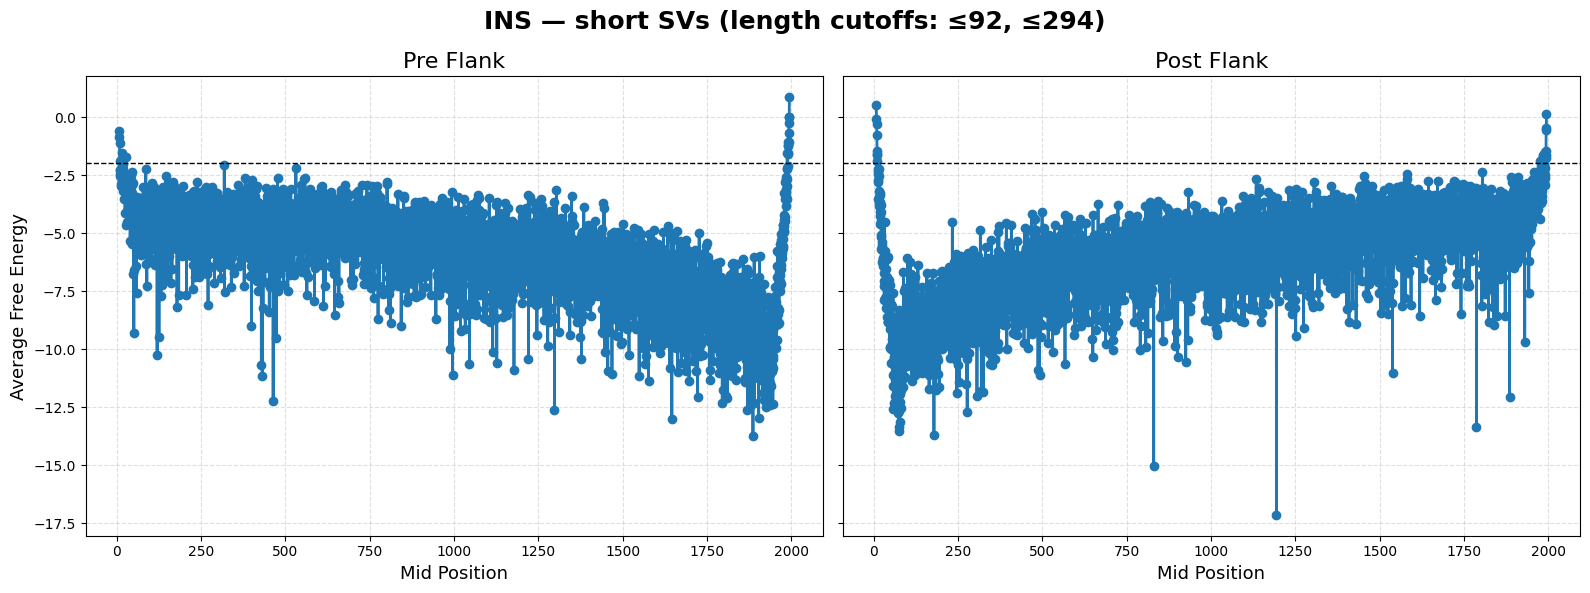

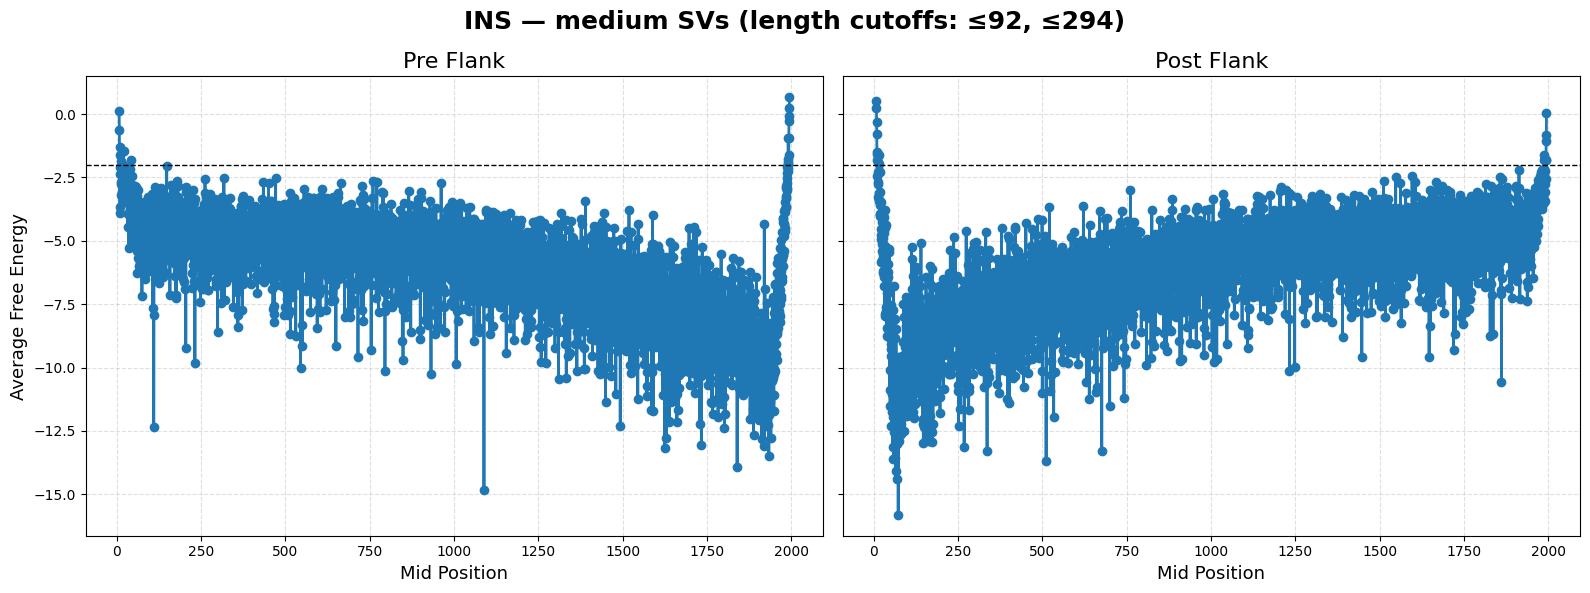

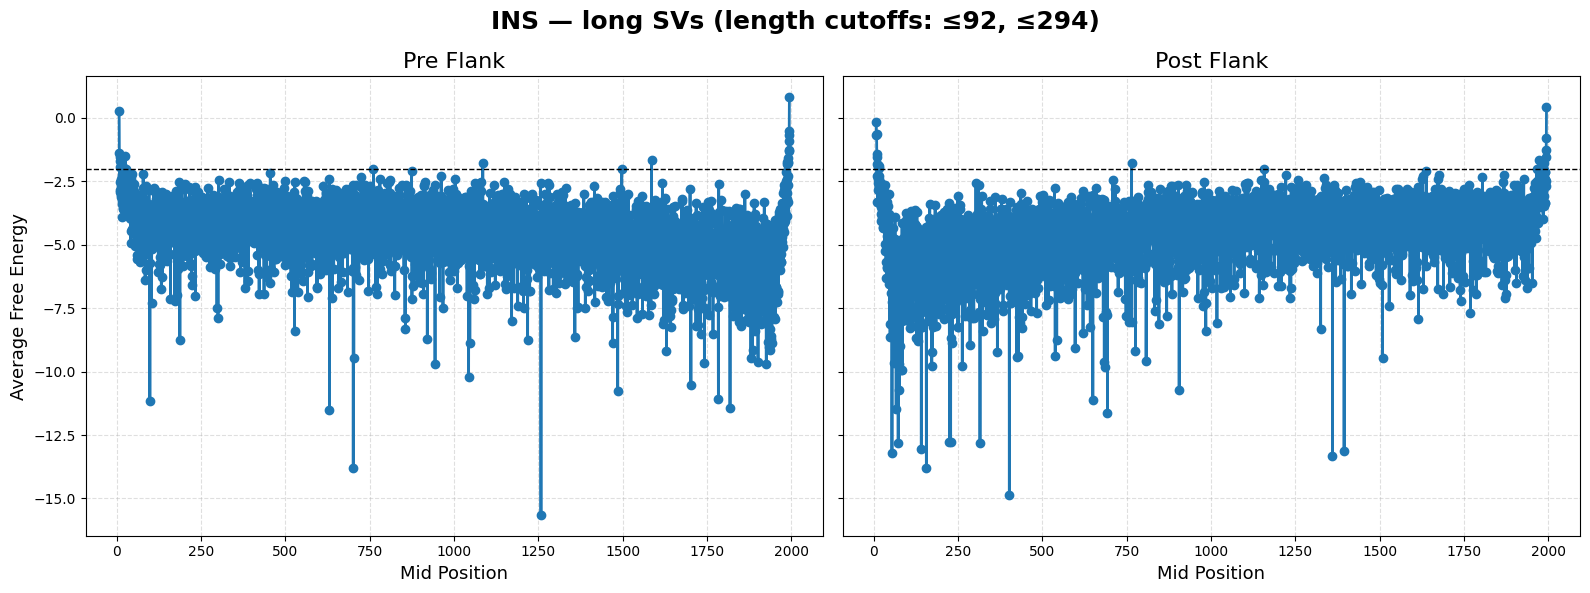

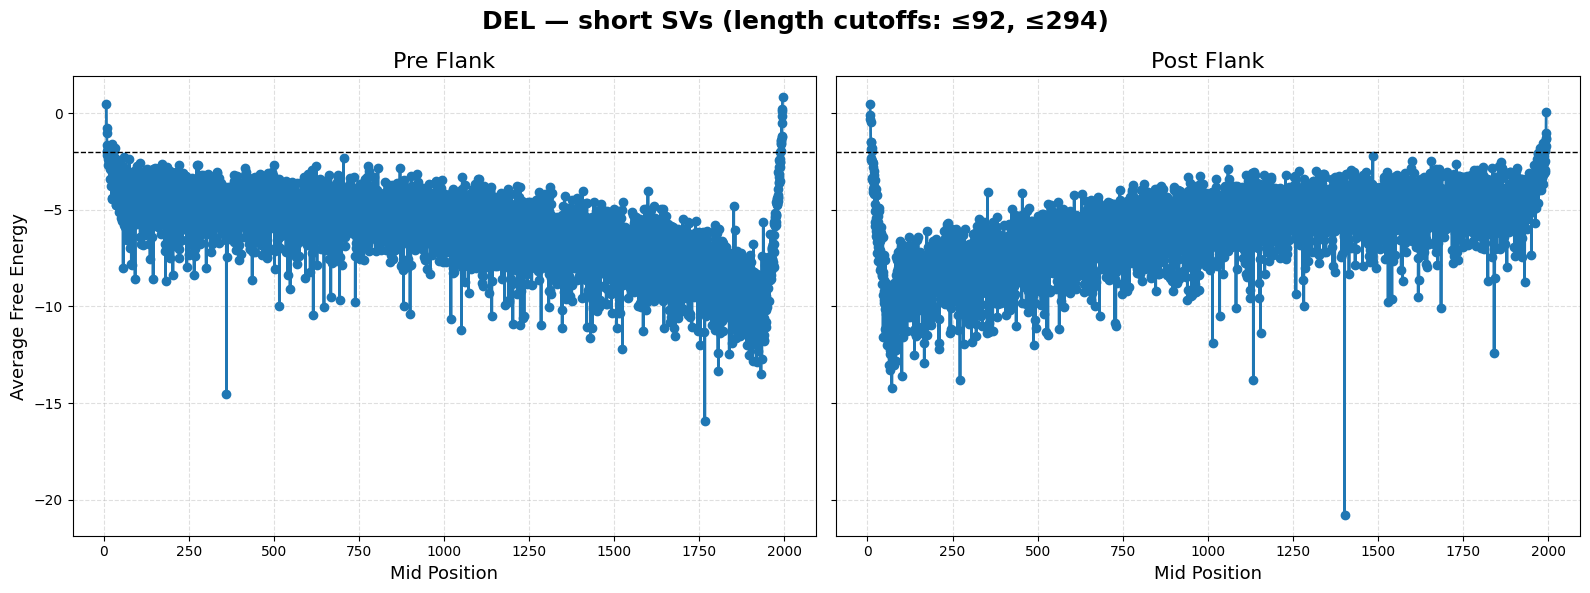

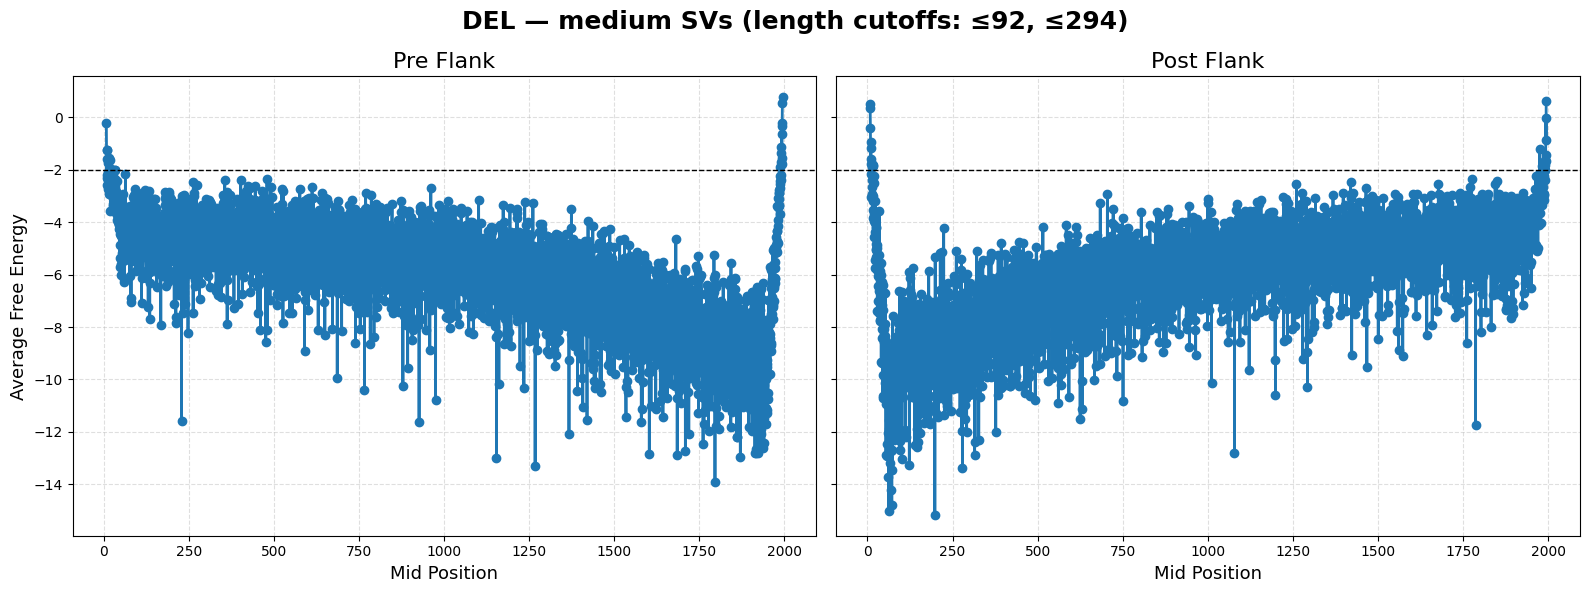

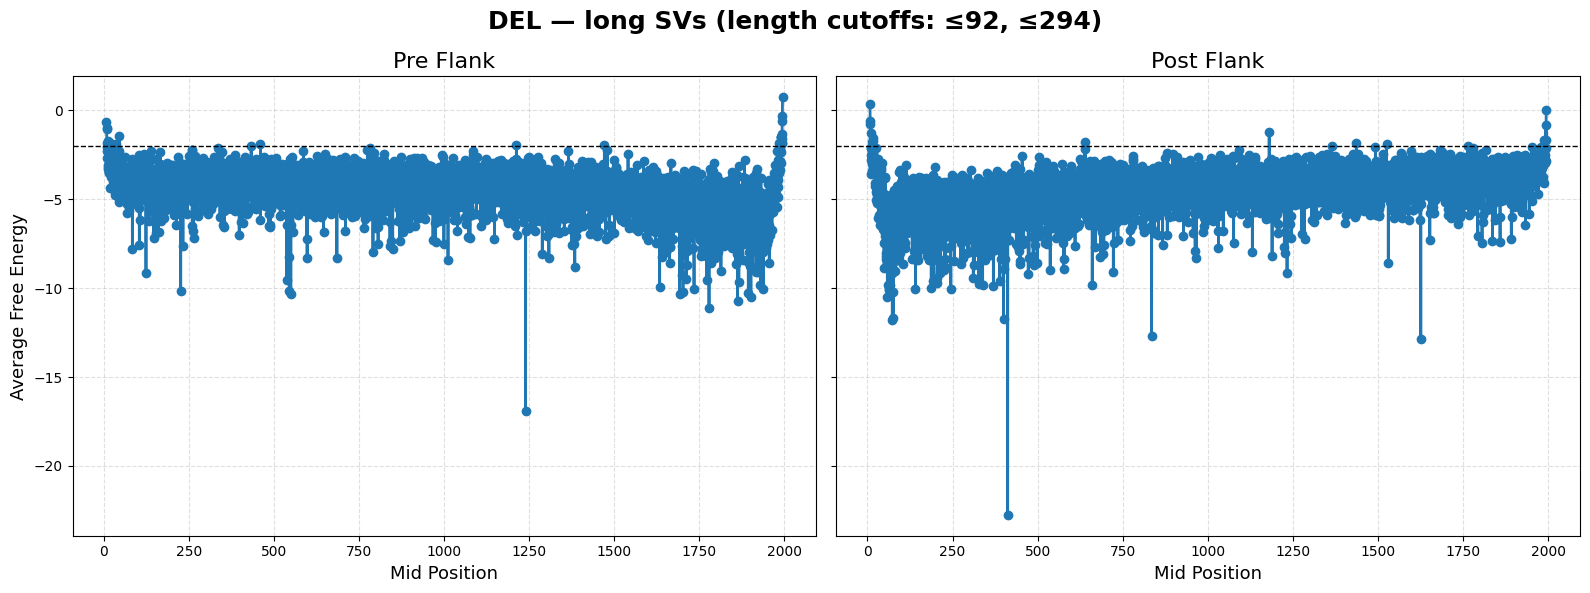

In [1]:
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIG =================
data_dir = "/home/alextu/scratch/free_energy_IRs_SVs/"
pattern  = "*NA*.tsv"
# Set manual thresholds if you want to force them; otherwise set to None to auto-compute from data tertiles
Q33_MANUAL = None   # e.g., 98
Q66_MANUAL = None   # e.g., 317
FLANKS     = ["pre_flank", "post_flank"]
SVTYPES    = ["INS", "DEL"]
FE_THRESH  = -2.0   # guide line on the plots
SAVE_FIGS  = False  # True to save PDFs
# ==========================================

# ---------- Load all TSVs ----------
tsv_files = glob.glob(os.path.join(data_dir, pattern))
if not tsv_files:
    raise FileNotFoundError(f"No files matched {os.path.join(data_dir, pattern)}")

frames = []
for fp in tsv_files:
    d = pd.read_csv(fp, sep="\t")
    d["Haplotype"] = os.path.basename(fp).split("_hap")[0]
    frames.append(d)
df = pd.concat(frames, ignore_index=True)

# ---------- Column detection ----------
if "Free_Energy" in df.columns:
    FREE_COL = "Free_Energy"
elif "Q" in df.columns:
    FREE_COL = "Q"
else:
    raise ValueError("Neither 'Free_Energy' nor 'Q' found in TSVs.")

# ---------- Basic fields ----------
def extract_flank(s):
    try:
        return str(s).split("|")[-1]
    except Exception:
        return "Unknown"

def extract_svtype(s):
    m = re.search(r'(?:^|[._|\-])(INS|DEL)(?:[._|\-]|$)', str(s), flags=re.IGNORECASE)
    return m.group(1).upper() if m else "Unknown"

# SV length: number right before _INS/_DEL
def extract_svlen(s):
    m = re.search(r'_(\d+)_(?:INS|DEL)(?:[._|\-|]|$)', str(s))
    return int(m.group(1)) if m else np.nan

df["Flank"]      = df["Sequence_name"].apply(extract_flank)
df["SVType"]     = df["Sequence_name"].apply(extract_svtype)
df["SV_Length"]  = df["Sequence_name"].apply(extract_svlen)

# Keep usable rows
df = df[df["SVType"].isin(SVTYPES) & df["Flank"].isin(FLANKS)].copy()
df = df.dropna(subset=["Start","Stop", FREE_COL, "SV_Length"])
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2.0

# ---------- Length bins (short / medium / long) ----------
if (Q33_MANUAL is not None) and (Q66_MANUAL is not None):
    q33, q66 = float(Q33_MANUAL), float(Q66_MANUAL)
else:
    # compute from the data
    q33, q66 = np.percentile(df["SV_Length"], [33, 66])

def length_cat(x):
    if x <= q33:  return "short"
    if x <= q66:  return "medium"
    return "long"

df["LengthCat"] = df["SV_Length"].apply(length_cat)
df["LengthCat"] = pd.Categorical(df["LengthCat"], categories=["short","medium","long"], ordered=True)

print(f"[INFO] SV length cutpoints: 33rd={q33:.1f}, 66th={q66:.1f}")

# ---------- Aggregation ----------
avg_fe = (
    df.groupby(["SVType","LengthCat","Flank","Mid_Position"], as_index=False)[FREE_COL]
      .mean()
      .rename(columns={FREE_COL: "Free_Energy_Avg"})
      .sort_values(["SVType","LengthCat","Flank","Mid_Position"])
)

# ---------- Plot helper ----------
def plot_pre_post_by_len(svtype, lenbin):
    sub = avg_fe[(avg_fe["SVType"]==svtype) & (avg_fe["LengthCat"]==lenbin)]
    if sub.empty:
        print(f"[WARN] No data for {svtype} / {lenbin}; skipping.")
        return

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.suptitle(f"{svtype} — {lenbin} SVs (length cutoffs: ≤{q33:.0f}, ≤{q66:.0f})",
                 fontsize=18, fontweight="bold")

    for i, flank in enumerate(FLANKS):
        ax = axs[i]
        pane = sub[sub["Flank"]==flank]
        ax.plot(pane["Mid_Position"], pane["Free_Energy_Avg"], marker="o", linewidth=2)
        ax.axhline(y=FE_THRESH, color="black", linestyle="--", linewidth=1)
        ax.set_title(flank.replace("_"," ").title(), fontsize=16)
        ax.set_xlabel("Mid Position", fontsize=13)
        if i == 0:
            ax.set_ylabel("Average Free Energy", fontsize=13)
        ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    if SAVE_FIGS:
        out = f"IR_avgFE_{svtype}_{lenbin}.pdf"
        plt.savefig(out, dpi=300, bbox_inches="tight")
        print(f"[OK] saved {out}")
    plt.show()

# ---------- Make the 6 figures ----------
for sv in SVTYPES:
    for lb in ["short","medium","long"]:
        plot_pre_post_by_len(sv, lb)

[INFO] SV length cutpoints: 33rd=92.0, 66th=294.0


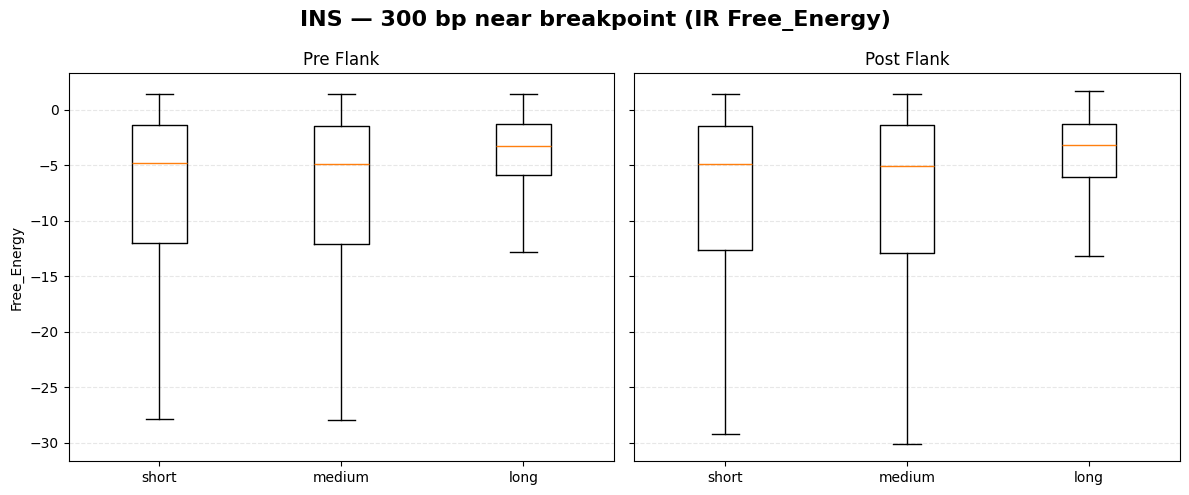

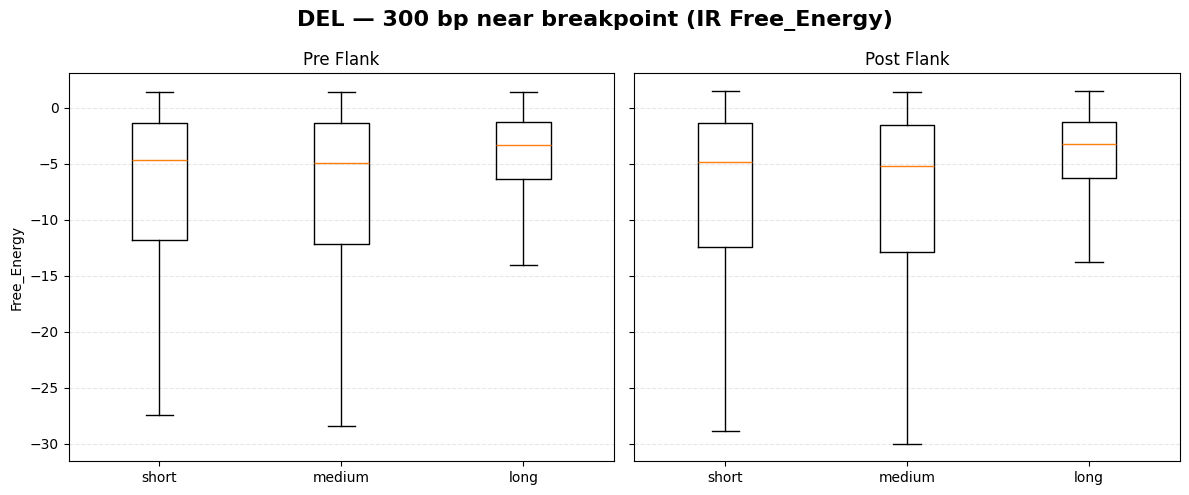

In [3]:
#!/usr/bin/env python3
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIG =================
data_dir     = "/home/alextu/scratch/free_energy_IRs_SVs/"
pattern      = "*NA*.tsv"
FLANKS       = ["pre_flank", "post_flank"]
SVTYPES      = ["INS", "DEL"]
NEAR_BP      = 300      # keep last 300 bp (pre) / first 300 bp (post)
FLANK_LEN    = 2000
Q33_MANUAL   = None     # e.g., 98
Q66_MANUAL   = None     # e.g., 317
SAVE_FIGS    = False
# ==========================================

# ---------- Load all TSVs ----------
tsv_files = glob.glob(os.path.join(data_dir, pattern))
if not tsv_files:
    raise FileNotFoundError(f"No files matched {os.path.join(data_dir, pattern)}")

frames = []
for fp in tsv_files:
    d = pd.read_csv(fp, sep="\t")
    d["Haplotype"] = os.path.basename(fp).split("_hap")[0]
    frames.append(d)
df = pd.concat(frames, ignore_index=True)

# ---------- Column detection ----------
if "Free_Energy" in df.columns:
    FREE_COL = "Free_Energy"
elif "Q" in df.columns:
    FREE_COL = "Q"
else:
    raise ValueError("Neither 'Free_Energy' nor 'Q' found in TSVs.")

# ---------- Helpers ----------
def extract_flank(s):
    try:
        return str(s).split("|")[-1]
    except Exception:
        return "Unknown"

def extract_svtype(s):
    m = re.search(r'(?:^|[._|\-])(INS|DEL)(?:[._|\-]|$)', str(s), flags=re.IGNORECASE)
    return m.group(1).upper() if m else "Unknown"

def extract_svlen(s):
    m = re.search(r'_(\d+)_(?:INS|DEL)(?:[._|\-|]|$)', str(s))
    return int(m.group(1)) if m else np.nan

# ---------- Basic fields ----------
df["Flank"]     = df["Sequence_name"].apply(extract_flank)
df["SVType"]    = df["Sequence_name"].apply(extract_svtype)
df["SV_Length"] = df["Sequence_name"].apply(extract_svlen)

for col in ["Start", "Stop", FREE_COL, "SV_Length"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["Start", "Stop", FREE_COL, "SV_Length"])
df = df[df["SVType"].isin(SVTYPES) & df["Flank"].isin(FLANKS)].copy()
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2.0

# ---------- Length bins ----------
if (Q33_MANUAL is not None) and (Q66_MANUAL is not None):
    q33, q66 = float(Q33_MANUAL), float(Q66_MANUAL)
else:
    q33, q66 = np.percentile(df["SV_Length"], [33, 66])

def length_cat(x):
    if x <= q33:  return "short"
    if x <= q66:  return "medium"
    return "long"

length_order = ["short", "medium", "long"]
df["LengthCat"] = pd.Categorical(df["SV_Length"].apply(length_cat),
                                 categories=length_order, ordered=True)

print(f"[INFO] SV length cutpoints: 33rd={q33:.1f}, 66th={q66:.1f}")

# ---------- Keep only near-breakpoint windows ----------
near_pre  = (df["Flank"]=="pre_flank")  & (df["Mid_Position"] >= (FLANK_LEN - NEAR_BP))
near_post = (df["Flank"]=="post_flank") & (df["Mid_Position"] < NEAR_BP)
df_near = df[near_pre | near_post].copy()

# ---------- Plotting: boxplots per SV type ----------
def boxplots_for_svtype(svtype_label):
    sub = df_near[df_near["SVType"]==svtype_label]
    if sub.empty:
        print(f"[WARN] No data for {svtype_label}; skipping.")
        return

    fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)
    fig.suptitle(f"{svtype_label} — {NEAR_BP} bp near breakpoint (IR {FREE_COL})",
                 fontsize=16, fontweight="bold")

    for i, flank in enumerate(FLANKS):
        ax = axs[i]
        pane = sub[sub["Flank"]==flank]
        # Data arrays in order short/medium/long
        data = [pane[pane["LengthCat"]==lc][FREE_COL].dropna().values for lc in length_order]

        # Boxplot
        ax.boxplot(data, showfliers=False)
        ax.set_xticks([1,2,3])
        ax.set_xticklabels(length_order, rotation=0)
        ax.set_title(flank.replace("_"," ").title())
        if i==0:
            ax.set_ylabel(FREE_COL)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout()
    if SAVE_FIGS:
        out = f"IR_{FREE_COL}_boxplots_nearBP_{svtype_label}.pdf"
        plt.savefig(out, dpi=300, bbox_inches="tight")
        print(f"[OK] saved {out}")
    plt.show()

# Make two figures
boxplots_for_svtype("INS")
boxplots_for_svtype("DEL")

[INFO] Rarity thresholds: rare ≤1, common ≥20


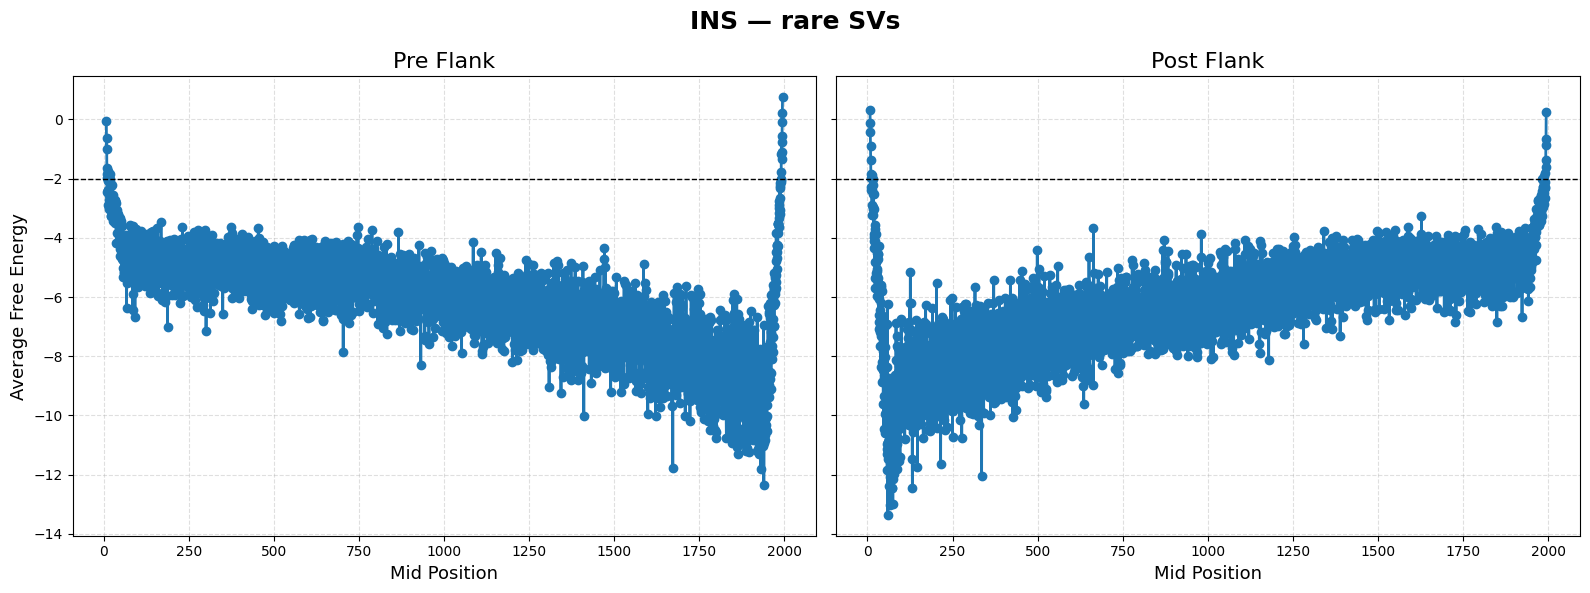

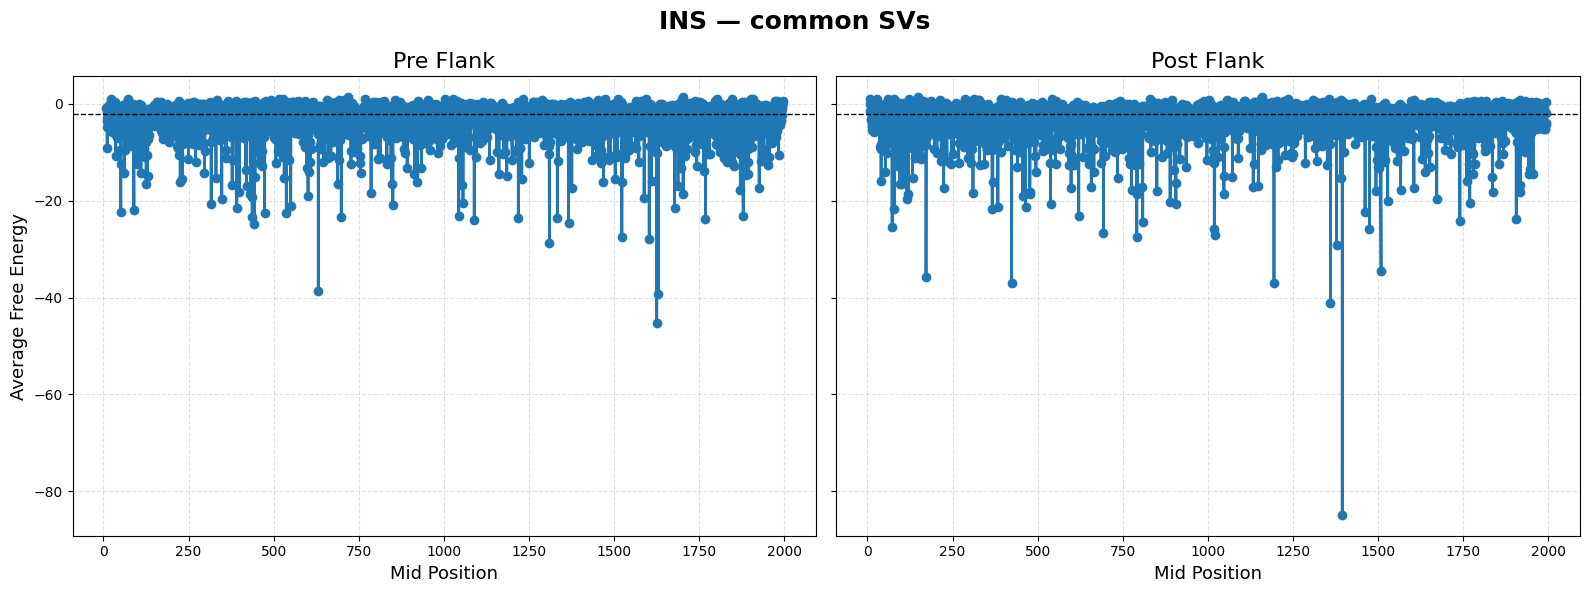

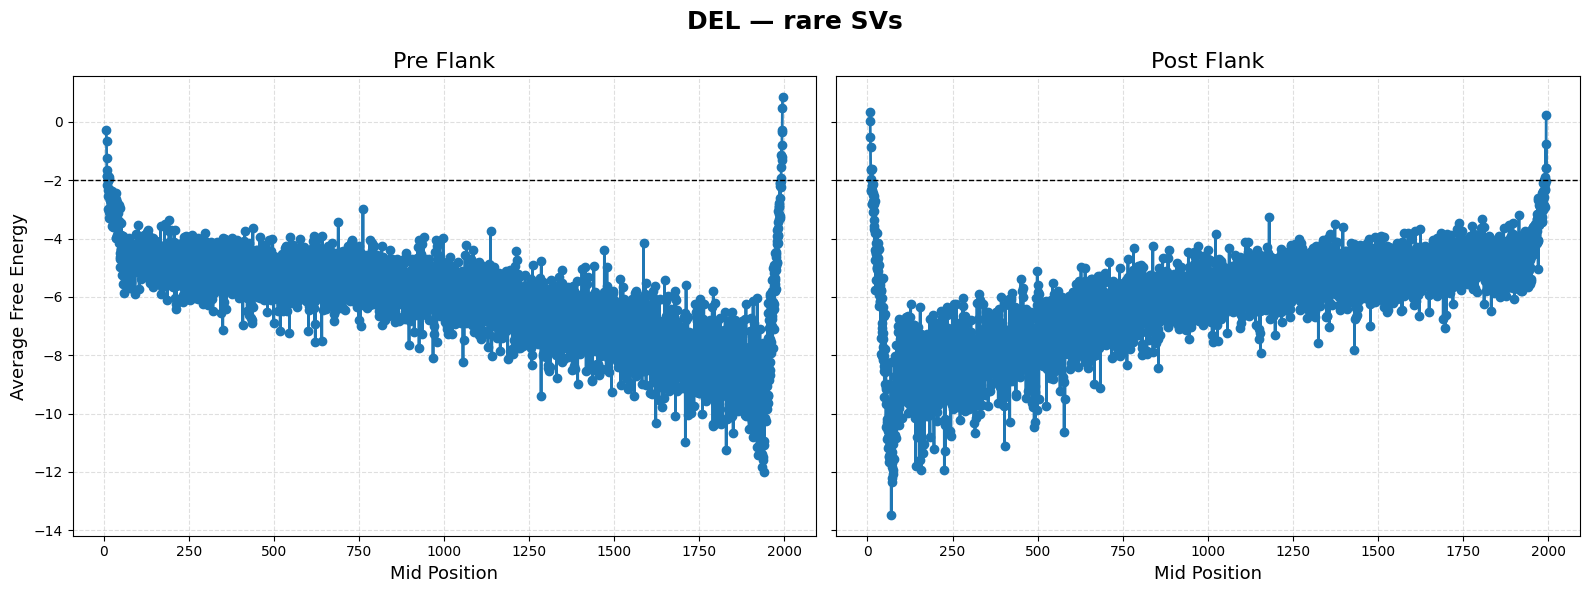

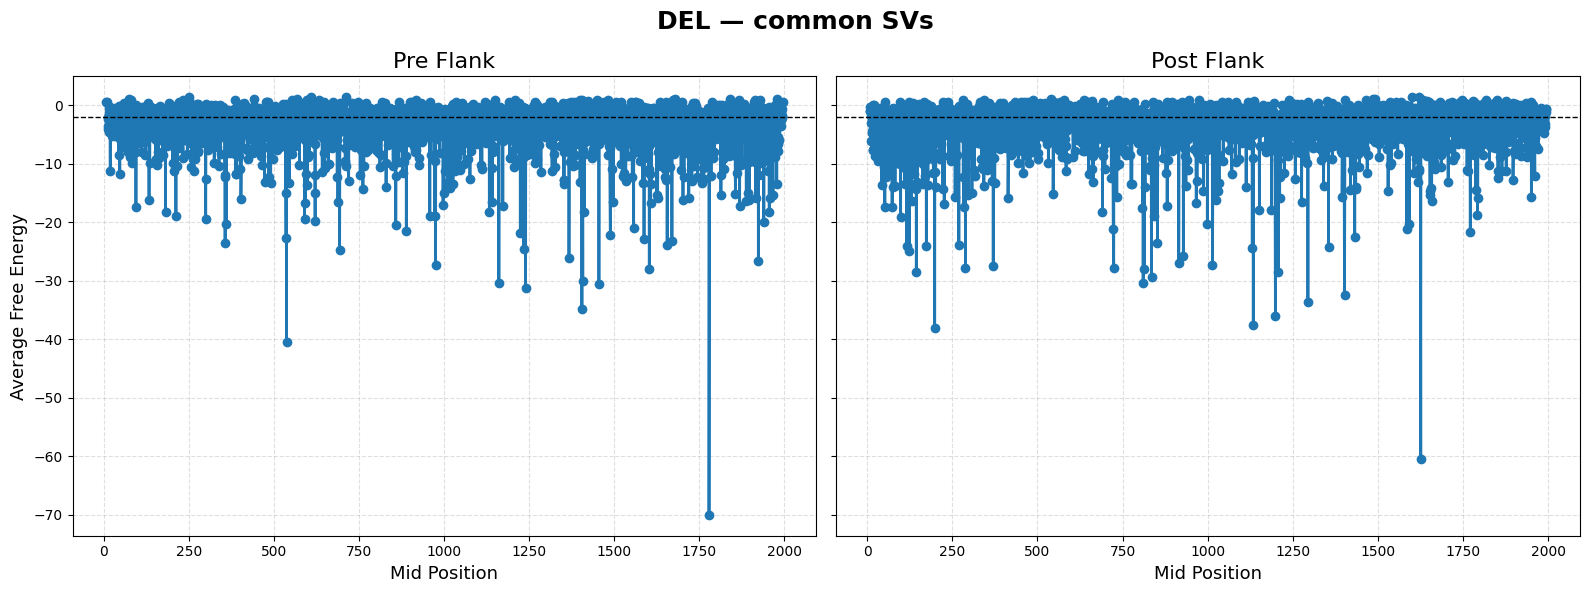

In [7]:
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIG =================
data_dir = "/home/alextu/scratch/free_energy_IRs_SVs/"
pattern  = "*NA*.tsv"

# Rarity cutoffs (number of haplotypes an SV is found in)
# If None → auto tertiles on haplotype counts
RARE_MAX_SAMPLES   = 1 # e.g. 2   (≤ rare_max → "rare")
COMMON_MIN_SAMPLES = 20  # e.g. 5   (≥ common_min → "common")

FLANKS     = ["pre_flank", "post_flank"]
SVTYPES    = ["INS", "DEL"]
FE_GUIDE   = -2.0
SAVE_FIGS  = False
OUTDIR     = "."
# ==========================================

# ---------- Load ----------
tsv_files = glob.glob(os.path.join(data_dir, pattern))
if not tsv_files:
    raise FileNotFoundError(f"No files matched {os.path.join(data_dir, pattern)}")

frames = []
for fp in tsv_files:
    d = pd.read_csv(fp, sep="\t")
    d["Haplotype"] = os.path.basename(fp).split("_hap")[0]
    frames.append(d)
df = pd.concat(frames, ignore_index=True)

# ---------- Free energy column ----------
if "Free_Energy" in df.columns:
    FREE_COL = "Free_Energy"
elif "Q" in df.columns:
    FREE_COL = "Q"
else:
    raise ValueError("Neither 'Free_Energy' nor 'Q' found in TSVs.")

# ---------- Extract SV info ----------
def extract_flank(s):
    return str(s).split("|")[-1]

def extract_svtype(s):
    m = re.search(r'(?:^|[._|\-])(INS|DEL)(?:[._|\-]|$)', str(s), flags=re.IGNORECASE)
    return m.group(1).upper() if m else "Unknown"

def extract_svkey(s):
    core = str(s).split("|")[0]  # drop flank part
    # Try chr-pos-len-type
    m = re.search(r'(chr[\w]+)[_\-](\d+).*?_(\d+)_(INS|DEL)', core, re.I)
    if m:
        return f"{m.group(1)}:{m.group(2)}:{m.group(3)}:{m.group(4).upper()}"
    return core  # fallback

df["Flank"]  = df["Sequence_name"].apply(extract_flank)
df["SVType"] = df["Sequence_name"].apply(extract_svtype)
df["SV_Key"] = df["Sequence_name"].apply(extract_svkey)

# Filter usable
df = df[df["SVType"].isin(SVTYPES) & df["Flank"].isin(FLANKS)].copy()
df = df.dropna(subset=["Start","Stop", FREE_COL, "SV_Key"])
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2.0

# ---------- Rarity counts ----------
occ = (
    df.groupby("SV_Key", as_index=False)["Haplotype"]
      .nunique()
      .rename(columns={"Haplotype":"Haplotype_Count"})
)

# Thresholds
if (RARE_MAX_SAMPLES is not None) and (COMMON_MIN_SAMPLES is not None):
    rare_max, common_min = RARE_MAX_SAMPLES, COMMON_MIN_SAMPLES
else:
    q33, q66 = np.percentile(occ["Haplotype_Count"], [33, 66])
    rare_max, common_min = int(np.floor(q33)), int(np.ceil(q66))

def rarity_label(n):
    if n <= rare_max: return "rare"
    if n >= common_min: return "common"
    return "mid"

occ["Rarity"] = occ["Haplotype_Count"].apply(rarity_label)
df = df.merge(occ[["SV_Key","Haplotype_Count","Rarity"]], on="SV_Key", how="left")

print(f"[INFO] Rarity thresholds: rare ≤{rare_max}, common ≥{common_min}")

# ---------- Aggregate ----------
avg_fe = (
    df.groupby(["SVType","Flank","Mid_Position","Rarity"], as_index=False)[FREE_COL]
      .mean()
      .rename(columns={FREE_COL:"Free_Energy_Avg"})
)

# ---------- Plot ----------
def plot_pre_post(svtype, rarity):
    sub = avg_fe[(avg_fe["SVType"]==svtype) & (avg_fe["Rarity"]==rarity)]
    if sub.empty:
        print(f"[WARN] No data for {svtype}/{rarity}")
        return

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.suptitle(f"{svtype} — {rarity} SVs", fontsize=18, fontweight="bold")

    for i, flank in enumerate(FLANKS):
        ax = axs[i]
        pane = sub[sub["Flank"]==flank]
        ax.plot(pane["Mid_Position"], pane["Free_Energy_Avg"], marker="o", linewidth=2)
        ax.axhline(y=FE_GUIDE, color="black", linestyle="--", linewidth=1)
        ax.set_title(flank.replace("_"," ").title(), fontsize=16)
        ax.set_xlabel("Mid Position", fontsize=13)
        if i == 0: ax.set_ylabel("Average Free Energy", fontsize=13)
        ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    if SAVE_FIGS:
        out = os.path.join(OUTDIR, f"IR_avgFE_{svtype}_{rarity}.pdf")
        plt.savefig(out, dpi=300, bbox_inches="tight")
        print(f"[OK] saved {out}")
    plt.show()

# ---------- Run ----------
for sv in SVTYPES:
    for rarity in ["rare","common"]:
        plot_pre_post(sv, rarity)

# Examining Free Energy (Stability) of Inverted Repeats in MEI Flanks

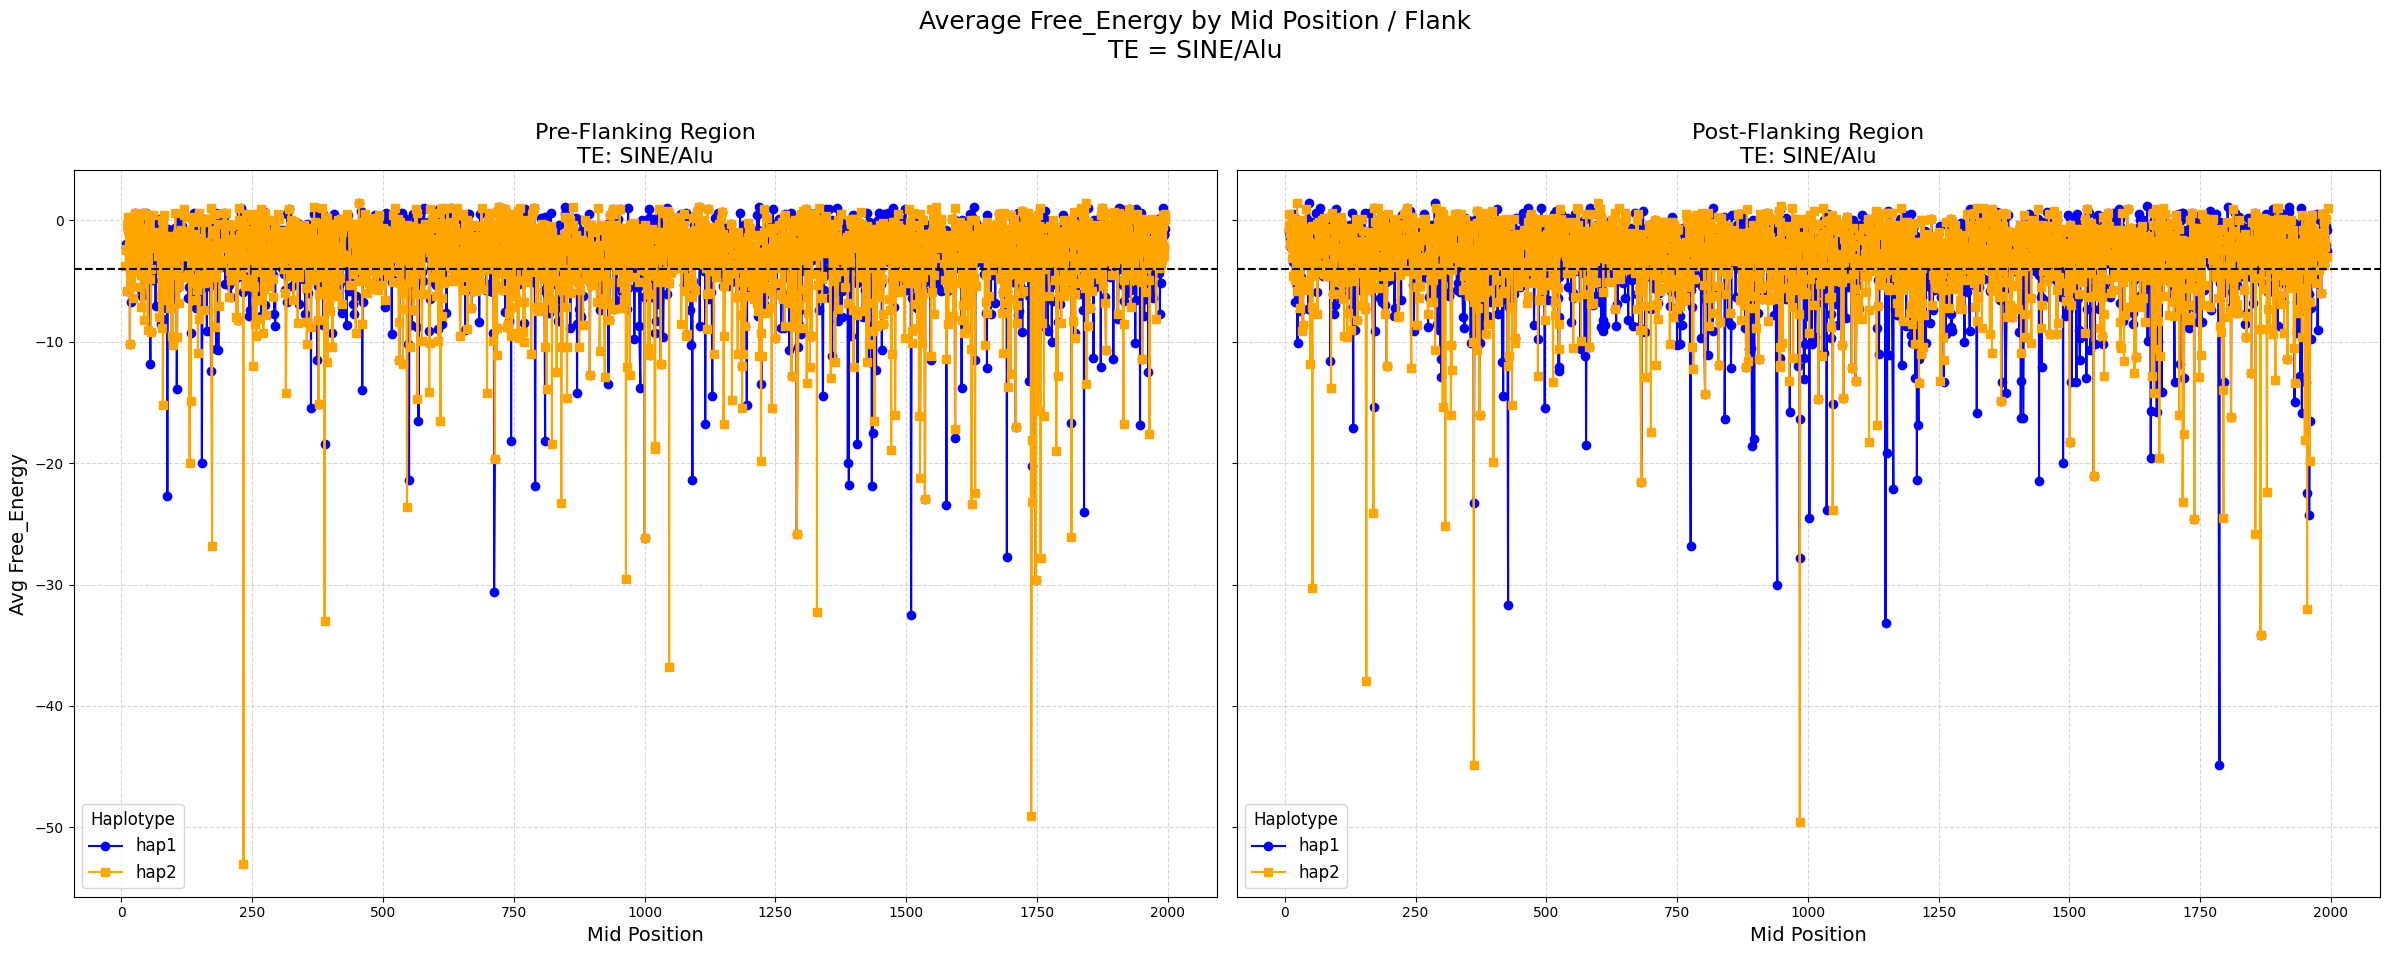

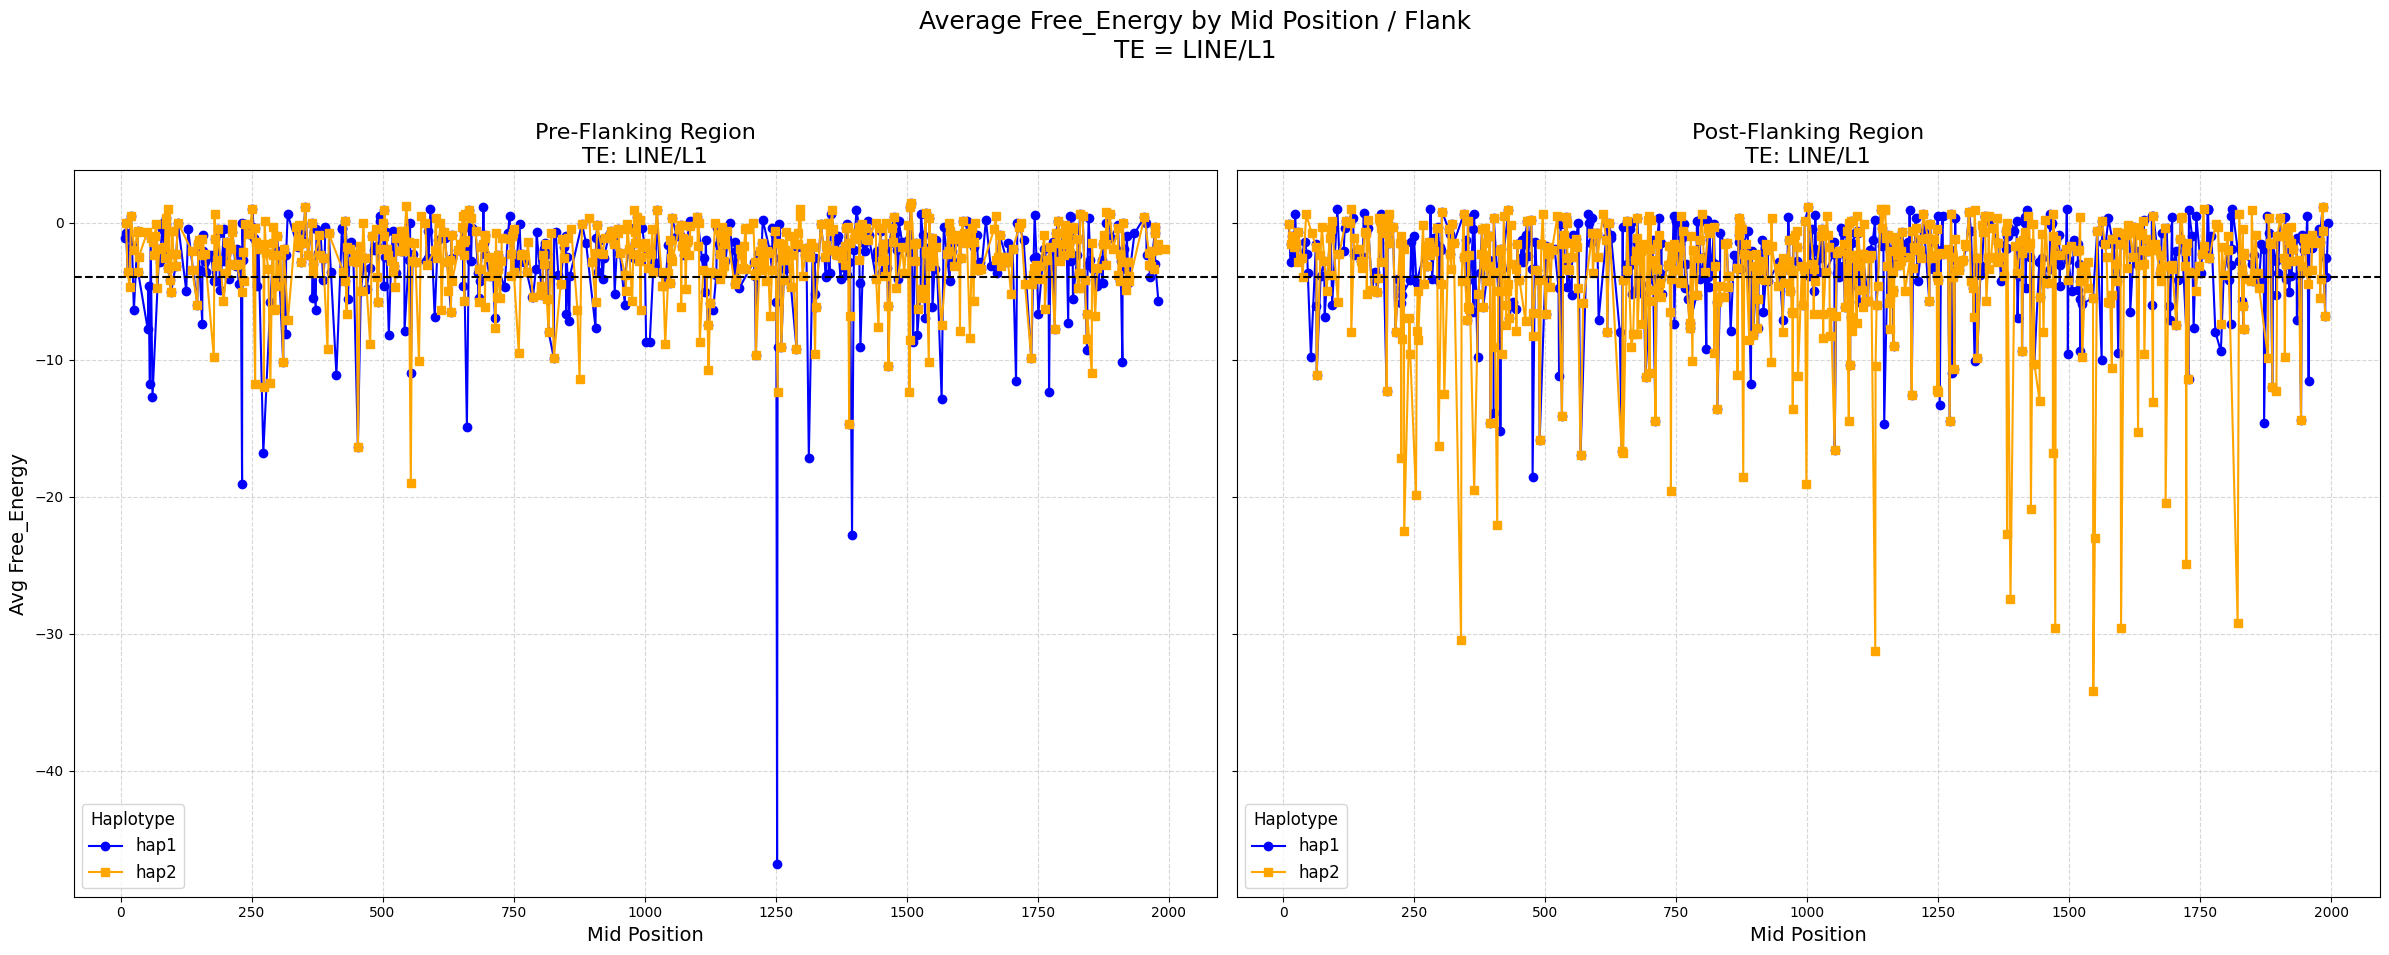

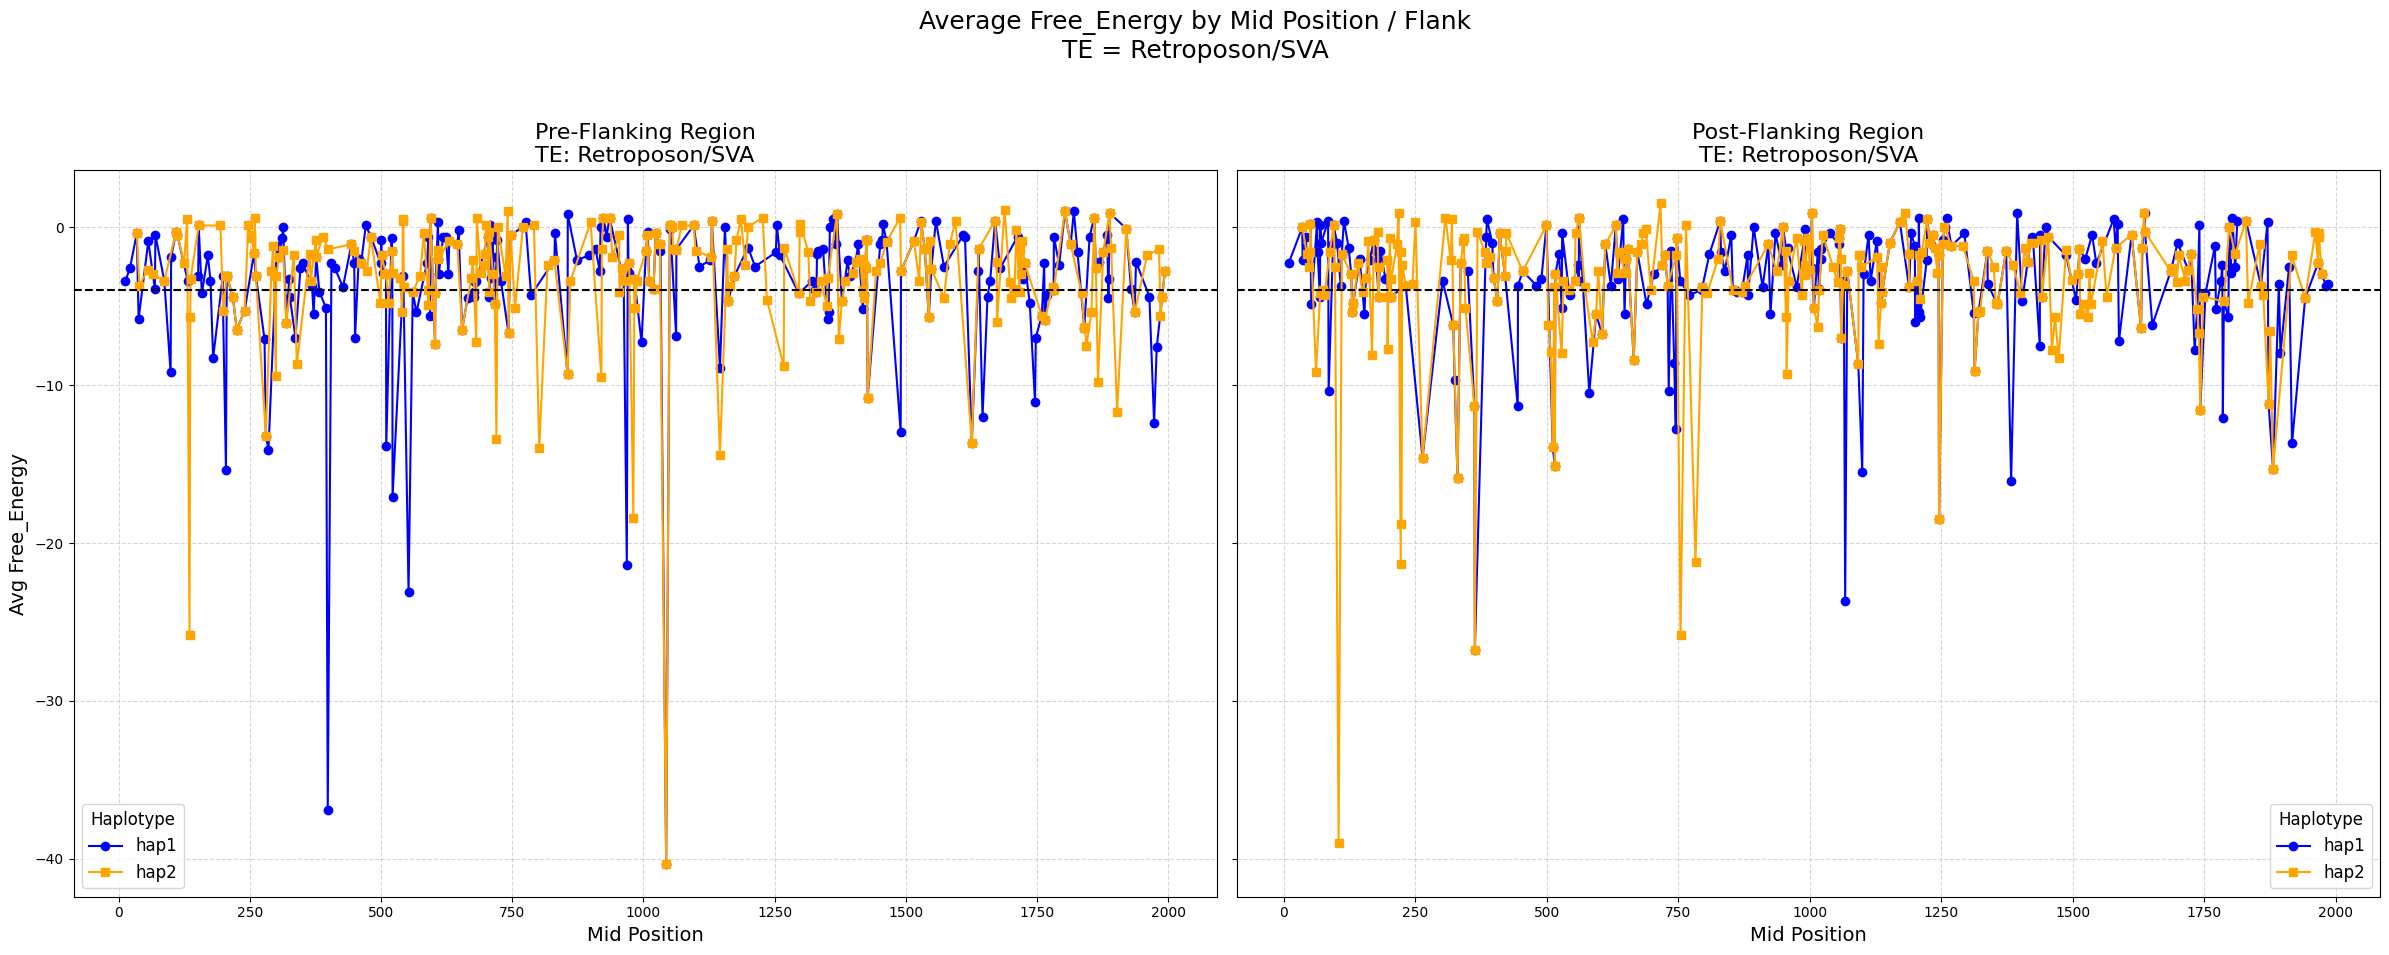


All done!


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# -------------------
# Step 1: Load and Process the Data
# -------------------

# Define the file paths
hap1_file = "/home/alextu/scratch/free_energy_IRs_MEIs_annotated/flanking_sequences_HG02059_hap1_IR_free_energy.tsv"
hap2_file = "/home/alextu/scratch/free_energy_IRs_MEIs_annotated/flanking_sequences_HG02059_hap2_IR_free_energy.tsv"

# Load the dataset for hap1 and hap2
hap1_df = pd.read_csv(hap1_file, sep="\t")
hap2_df = pd.read_csv(hap2_file, sep="\t")

# Function to categorize stability with Free Energy ranges in labels (same as your code)
def categorize_stability(value):
    if value <= -10:
        return "Highly Stable\n($\leq$ -10)"
    elif value <= -2:
        return "Moderately Stable\n(-10 < x $\leq$ -2)"
    else:
        return "Unstable\n(> -2)"

# Check which column we have for free energy (Free_Energy vs. Q)
energy_col = None
if 'Free_Energy' in hap1_df.columns:
    energy_col = 'Free_Energy'
elif 'Q' in hap1_df.columns:
    energy_col = 'Q'
else:
    raise ValueError("Neither 'Free_Energy' nor 'Q' column found in hap1_df.")

# Apply the categorization
hap1_df["Stability"] = hap1_df[energy_col].apply(categorize_stability)
hap2_df["Stability"] = hap2_df[energy_col].apply(categorize_stability)

# Function to extract flanking region from Sequence_name column
def extract_flank(sequence_name):
    try:
        # Last part after '|' is either 'pre_flank' or 'post_flank'
        return sequence_name.split('|')[-1]
    except:
        return "Unknown"

hap1_df["Flank"] = hap1_df["Sequence_name"].apply(extract_flank)
hap2_df["Flank"] = hap2_df["Sequence_name"].apply(extract_flank)

# Create a new column 'Mid_Position'
hap1_df["Mid_Position"] = (hap1_df["Start"] + hap1_df["Stop"]) / 2
hap2_df["Mid_Position"] = (hap2_df["Start"] + hap2_df["Stop"]) / 2

# Now, suppose your .tsv also has a 'te_designation' column.
# If not, you'll need to parse it out. We'll assume it's already there.

# -------------------
# Step 2: Loop over each TE designation and plot
# -------------------

# Get unique TE designations from BOTH hap1 and hap2 (union)
# so you can loop over them
all_tes_hap1 = hap1_df['te_designation'].dropna().unique()
all_tes_hap2 = hap2_df['te_designation'].dropna().unique()
unique_tes = pd.Series(list(all_tes_hap1) + list(all_tes_hap2)).unique()

for te in unique_tes:
    # Filter hap1 for this TE
    hap1_te = hap1_df[hap1_df['te_designation'] == te].copy()
    # Filter hap2 for this TE
    hap2_te = hap2_df[hap2_df['te_designation'] == te].copy()
    
    # If there's no data in both hap1_te and hap2_te, skip
    if len(hap1_te) == 0 and len(hap2_te) == 0:
        continue

    # 1) Group by (Flank, Mid_Position), compute average free energy
    #    This is your "plot 2" logic but for each TE
    hap1_avg = hap1_te.groupby(["Flank", "Mid_Position"])[energy_col].mean().reset_index()
    hap2_avg = hap2_te.groupby(["Flank", "Mid_Position"])[energy_col].mean().reset_index()
    
    # 2) We'll create a figure with two subplots (pre and post flank)
    fig, axs = plt.subplots(1, 2, figsize=(24, 10), sharey=True)
    
    # For each subplot, we'll split hap1_avg/hap2_avg into pre/post, then plot
    # Colors for hap1 vs. hap2
    color_hap1 = 'blue'
    color_hap2 = 'orange'
    
    # -------------------
    # Subplot 1: Pre-Flank
    # -------------------
    hap1_pre = hap1_avg[hap1_avg["Flank"].str.contains("pre_flank", na=False)]
    hap2_pre = hap2_avg[hap2_avg["Flank"].str.contains("pre_flank", na=False)]
    
    axs[0].plot(hap1_pre["Mid_Position"], hap1_pre[energy_col], label='hap1', color=color_hap1, marker='o')
    axs[0].plot(hap2_pre["Mid_Position"], hap2_pre[energy_col], label='hap2', color=color_hap2, marker='s')
    
    # Add a horizontal line at, say, -4 (or -2?), adjust as you wish
    axs[0].axhline(y=-4, color='black', linestyle='--', linewidth=1.5)
    
    axs[0].set_title(f"Pre-Flanking Region\nTE: {te}", fontsize=16)
    axs[0].set_xlabel("Mid Position", fontsize=14)
    axs[0].set_ylabel(f"Avg {energy_col}", fontsize=14)
    axs[0].legend(title="Haplotype", fontsize=12, title_fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.5)
    
    # -------------------
    # Subplot 2: Post-Flank
    # -------------------
    hap1_post = hap1_avg[hap1_avg["Flank"].str.contains("post_flank", na=False)]
    hap2_post = hap2_avg[hap2_avg["Flank"].str.contains("post_flank", na=False)]
    
    axs[1].plot(hap1_post["Mid_Position"], hap1_post[energy_col], label='hap1', color=color_hap1, marker='o')
    axs[1].plot(hap2_post["Mid_Position"], hap2_post[energy_col], label='hap2', color=color_hap2, marker='s')
    
    # Horizontal line again
    axs[1].axhline(y=-4, color='black', linestyle='--', linewidth=1.5)
    
    axs[1].set_title(f"Post-Flanking Region\nTE: {te}", fontsize=16)
    axs[1].set_xlabel("Mid Position", fontsize=14)
    axs[1].legend(title="Haplotype", fontsize=12, title_fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.5)
    
    plt.suptitle(f"Average {energy_col} by Mid Position / Flank\nTE = {te}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the figure
    #outname = f"avg_{energy_col}_vs_midpos_flanks_{te}.pdf"
    #plt.savefig(outname, format='pdf', dpi=300, bbox_inches='tight')
    #print(f"Saved figure: {outname}")
    
    plt.show()

print("\nAll done!")

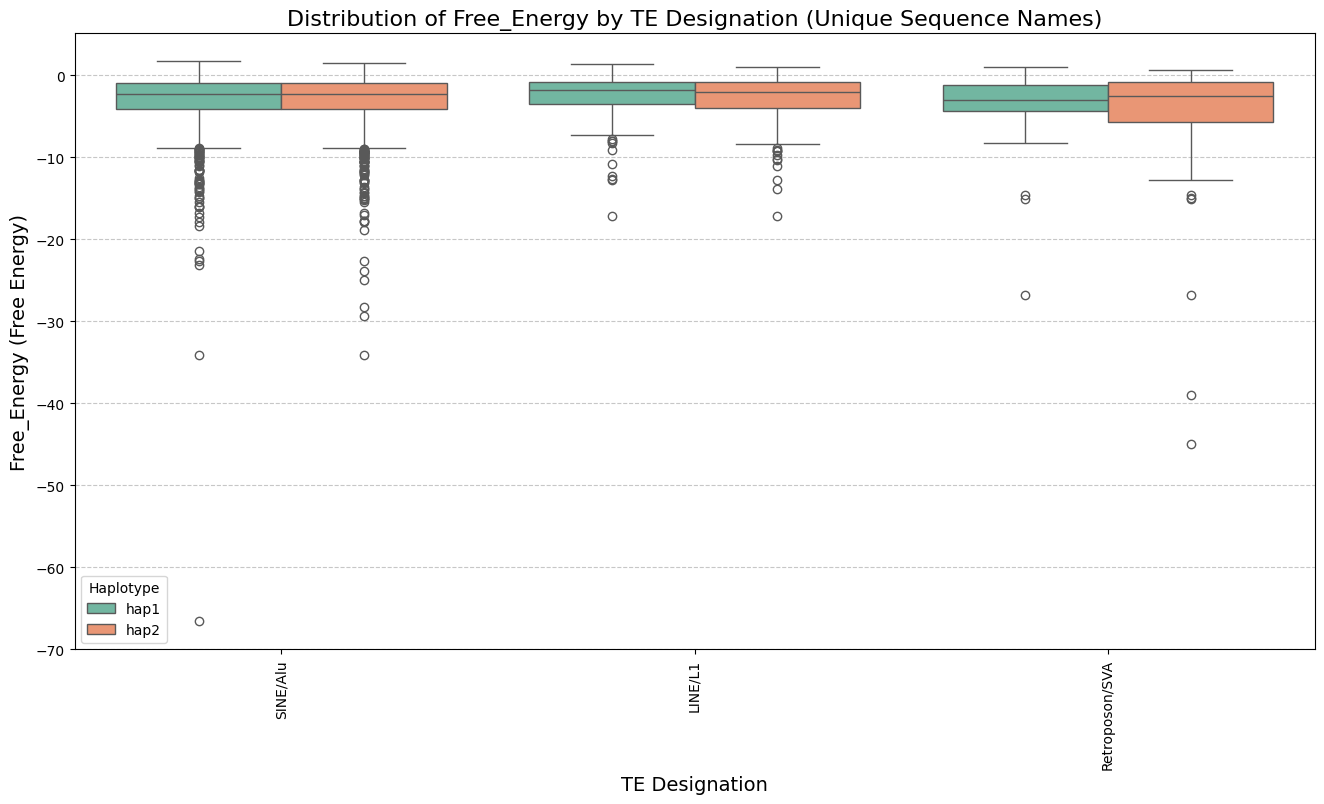

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------
# Load and Process the Data
# -------------------

# Define the file paths
hap1_file = "/home/alextu/scratch/free_energy_IRs_MEIs_annotated/flanking_sequences_HG00096_hap1_IR_free_energy.tsv"
hap2_file = "/home/alextu/scratch/free_energy_IRs_MEIs_annotated/flanking_sequences_HG00096_hap2_IR_free_energy.tsv"

# Load the dataset for hap1 and hap2
hap1_df = pd.read_csv(hap1_file, sep="\t")
hap2_df = pd.read_csv(hap2_file, sep="\t")

# Determine the correct column for Free Energy
energy_col = 'Free_Energy'  # Since we only have Free_Energy

# Remove duplicates based on Sequence_name
hap1_df = hap1_df.drop_duplicates(subset=["Sequence_name"])
hap2_df = hap2_df.drop_duplicates(subset=["Sequence_name"])

# Add haplotype labels
hap1_df["Haplotype"] = "hap1"
hap2_df["Haplotype"] = "hap2"

# Combine both datasets
combined_df = pd.concat([hap1_df, hap2_df])

# -------------------
# Create Boxplot of Free Energy by TE Designation
# -------------------

plt.figure(figsize=(16, 8))
sns.boxplot(data=combined_df, x="te_designation", y=energy_col, hue="Haplotype", palette="Set2")

plt.xlabel("TE Designation", fontsize=14)
plt.ylabel(f"{energy_col} (Free Energy)", fontsize=14)
plt.title(f"Distribution of {energy_col} by TE Designation (Unique Sequence Names)", fontsize=16)
plt.xticks(rotation=90)
plt.legend(title="Haplotype")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

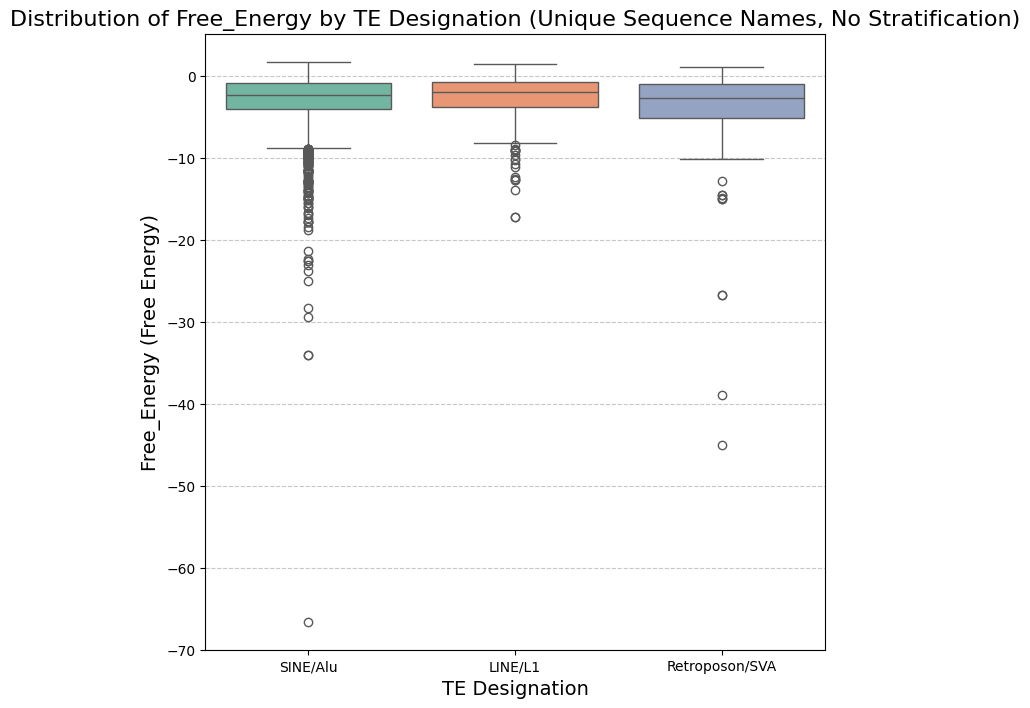

    Group 1         Group 2  KS Statistic   p-value
0  SINE/Alu         LINE/L1      0.086394  0.017688
1  SINE/Alu  Retroposon/SVA      0.107631  0.111440
2   LINE/L1  Retroposon/SVA      0.164618  0.010962


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from itertools import combinations

# -------------------
# Load and Process the Data
# -------------------

# Define the file paths
hap1_file = "/home/alextu/scratch/free_energy_IRs_MEIs_annotated/flanking_sequences_HG00096_hap1_IR_free_energy.tsv"
hap2_file = "/home/alextu/scratch/free_energy_IRs_MEIs_annotated/flanking_sequences_HG00096_hap2_IR_free_energy.tsv"

# Load the dataset for hap1 and hap2
hap1_df = pd.read_csv(hap1_file, sep="\t")
hap2_df = pd.read_csv(hap2_file, sep="\t")

# Determine the correct column for Free Energy
energy_col = 'Free_Energy'  # Since we only have Free_Energy

# Remove duplicates based on Sequence_name
hap1_df = hap1_df.drop_duplicates(subset=["Sequence_name"])
hap2_df = hap2_df.drop_duplicates(subset=["Sequence_name"])

# Combine both datasets
combined_df = pd.concat([hap1_df, hap2_df])

# -------------------
# Create Boxplot of Free Energy by TE Designation (No Stratification by Haplotype)
# -------------------

plt.figure(figsize=(8, 8))
ax = sns.boxplot(data=combined_df, x="te_designation", y=energy_col, hue="te_designation", palette="Set2", legend=False)

plt.xlabel("TE Designation", fontsize=14)
plt.ylabel(f"{energy_col} (Free Energy)", fontsize=14)
plt.title(f"Distribution of {energy_col} by TE Designation (Unique Sequence Names, No Stratification)", fontsize=16)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# -------------------
# Kolmogorov-Smirnov (KS) Test for Each TE Designation Pair
# -------------------

te_designations = list(combined_df["te_designation"].unique())
results = []
significant_pairs = []

for group1, group2 in combinations(te_designations, 2):
    data1 = combined_df.loc[combined_df["te_designation"] == group1, energy_col]
    data2 = combined_df.loc[combined_df["te_designation"] == group2, energy_col]
    
    if len(data1) > 0 and len(data2) > 0:
        stat, p_value = ks_2samp(data1, data2)
        results.append([group1, group2, stat, p_value])
        if p_value < 0.01:
            significant_pairs.append((group1, group2))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Group 1", "Group 2", "KS Statistic", "p-value"])

# Add significance markers to the plot
for i, (group1, group2) in enumerate(significant_pairs):
    x1, x2 = te_designations.index(group1), te_designations.index(group2)
    y_max = combined_df[energy_col].max() * 1.05
    plt.plot([x1, x1, x2, x2], [y_max, y_max + 1, y_max + 1, y_max], lw=1.5, c='black')
    plt.text((x1 + x2) * 0.5, y_max + 1.5, "*", ha='center', va='bottom', fontsize=14, color='black')

plt.show()

# Display results
print(results_df)


# Stability Analysis for Actual MEI Sequences....

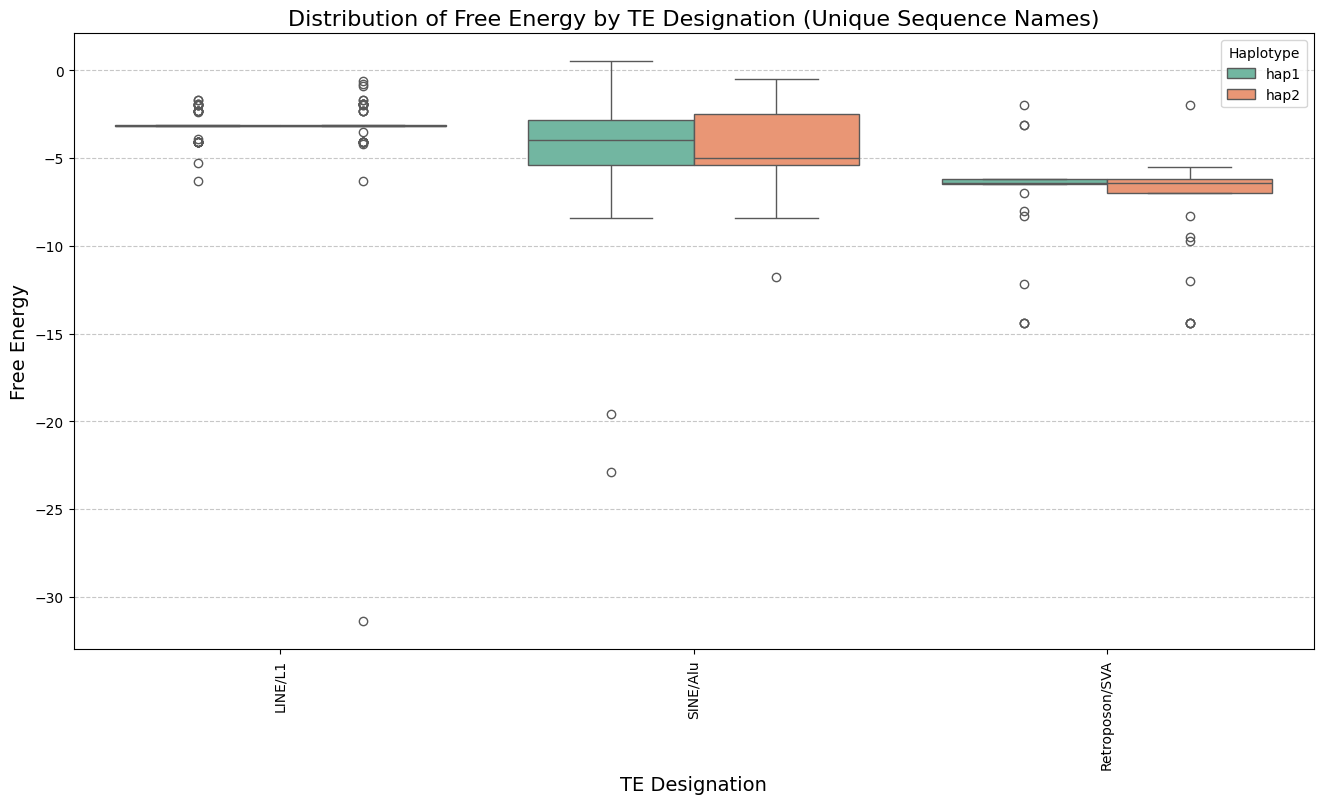

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------
# Load and Process the Data
# -------------------

# Define the file paths
hap1_file = "/home/alextu/scratch/free_energy_IRS_MEI_sequence_annotated/HG00096.h1.MEI_IR_free_energy.tsv"  # Update with actual path
hap2_file = "/home/alextu/scratch/free_energy_IRS_MEI_sequence_annotated/HG00096.h2.MEI_IR_free_energy.tsv"  # Update with actual path

# Load the datasets
hap1_df = pd.read_csv(hap1_file, sep="\t")
hap2_df = pd.read_csv(hap2_file, sep="\t")

# Column for Free Energy
energy_col = 'Free_Energy'  # Since we only have Free_Energy

# Remove duplicates based on Sequence_name
hap1_df = hap1_df.drop_duplicates(subset=["Sequence_name"])
hap2_df = hap2_df.drop_duplicates(subset=["Sequence_name"])

# Add haplotype labels
hap1_df["Haplotype"] = "hap1"
hap2_df["Haplotype"] = "hap2"

# Combine both haplotypes
combined_df = pd.concat([hap1_df, hap2_df])

# -------------------
# Create Boxplot of Free Energy by TE Designation
# -------------------

plt.figure(figsize=(16, 8))
sns.boxplot(data=combined_df, x="te_designation", y=energy_col, hue="Haplotype", palette="Set2")

plt.xlabel("TE Designation", fontsize=14)
plt.ylabel("Free Energy", fontsize=14)
plt.title("Distribution of Free Energy by TE Designation (Unique Sequence Names)", fontsize=16)
plt.xticks(rotation=90)
plt.legend(title="Haplotype")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

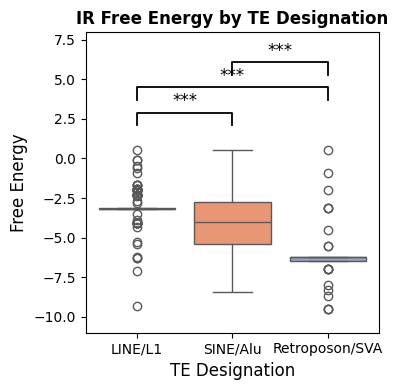

    Group 1         Group 2  KS Statistic   Raw p-value   Adj p-value
0   LINE/L1        SINE/Alu      0.512529  4.202720e-14  4.202720e-14
1   LINE/L1  Retroposon/SVA      0.886895  1.726002e-49  5.178005e-49
2  SINE/Alu  Retroposon/SVA      0.815617  1.167687e-27  1.751530e-27


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# -------------------
# Load and Process the Data
# -------------------

# Define the file paths
hap1_file = "/home/alextu/scratch/mei_analysis/free_energy_IRS_MEI_sequence_annotated/HG00096.h1.MEI_IR_free_energy.tsv"
hap2_file = "/home/alextu/scratch/mei_analysis/free_energy_IRS_MEI_sequence_annotated/HG03520.h1.MEI_IR_free_energy.tsv"

# Load the datasets
hap1_df = pd.read_csv(hap1_file, sep="\t")
hap2_df = pd.read_csv(hap2_file, sep="\t")

# Column for Free Energy
energy_col = 'Free_Energy'

# Remove duplicates based on Sequence_name
hap1_df = hap1_df.drop_duplicates(subset=["Sequence_name"])
hap2_df = hap2_df.drop_duplicates(subset=["Sequence_name"])

# Combine both haplotypes
combined_df = pd.concat([hap1_df, hap2_df])

# Drop NAs just in case
combined_df = combined_df.dropna(subset=[energy_col, "te_designation"])
tes = list(combined_df["te_designation"].unique())

# -------------------
# Create Boxplot of Free Energy by TE Designation
# -------------------

plt.figure(figsize=(4, 4))
ax = sns.boxplot(data=combined_df, x="te_designation", y=energy_col, hue="te_designation", palette="Set2", legend=False)

plt.xlabel("TE Designation", fontsize=12)
plt.ylabel("Free Energy", fontsize=12)
#plt.title("IR Free Energy by TE Designation", fontsize=12, fontweight="bold")
plt.xticks(rotation=0)
#plt.grid(axis="y", linestyle="--", alpha=0.7)

# -------------------
# Pairwise KS Tests + FDR Correction
# -------------------

results = []
pairs = list(combinations(tes, 2))

for g1, g2 in pairs:
    d1 = combined_df[combined_df["te_designation"] == g1][energy_col]
    d2 = combined_df[combined_df["te_designation"] == g2][energy_col]
    stat, p = ks_2samp(d1, d2)
    results.append((g1, g2, stat, p))

results_df = pd.DataFrame(results, columns=["Group 1", "Group 2", "KS Statistic", "Raw p-value"])

# FDR correction
results_df["Adj p-value"] = multipletests(results_df["Raw p-value"], method="fdr_bh")[1]

# -------------------
# Annotate Significance
# -------------------

y_max = combined_df[energy_col].max()
h = (y_max - combined_df[energy_col].min()) * 0.05
offset = y_max + h

for i, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p = row["Adj p-value"]
    x1, x2 = tes.index(g1), tes.index(g2)
    y = offset + i * h

    # Plot connector line
    plt.plot([x1, x1, x2, x2], [y, y + h/2, y + h/2, y], lw=1.3, c="black")

    # Decide star label
    star = (
        "***" if p < 0.001 else
        "**" if p < 0.01 else
        "*" if p < 0.05 else
        "ns"
    )
    plt.text((x1 + x2) / 2, y + h * 0.6, star, ha="center", va="bottom", fontsize=12)
    
plt.ylim(bottom=-11)    
plt.tight_layout()
plt.savefig("/home/alextu/projects/def-sushant/alextu/PhasedHapAssembly-nonB/imgs_no_titles/IR_mei_free_energy.pdf", dpi=300)
plt.show()

# Display raw + adjusted results
print(results_df)

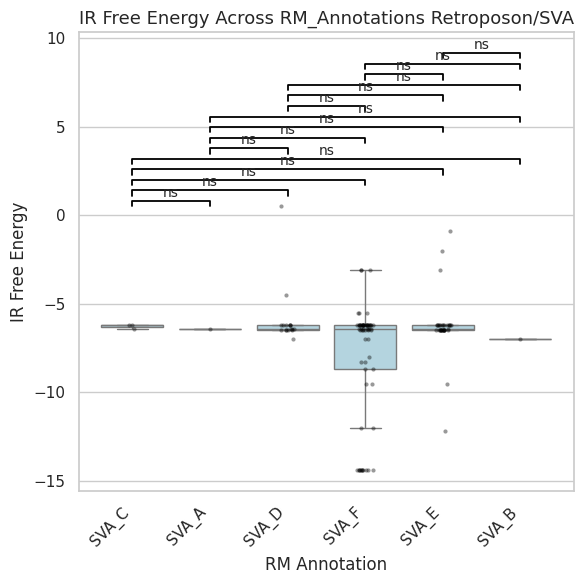

   Group 1 Group 2  KS Statistic  Raw p-value  Adj p-value
0    SVA_C   SVA_A      0.666667     1.000000     1.000000
1    SVA_C   SVA_D      0.352941     0.810526     1.000000
2    SVA_C   SVA_F      0.437500     0.518380     1.000000
3    SVA_C   SVA_E      0.500000     0.385199     1.000000
4    SVA_C   SVA_B      1.000000     0.500000     1.000000
5    SVA_A   SVA_D      0.470588     1.000000     1.000000
6    SVA_A   SVA_F      0.453125     1.000000     1.000000
7    SVA_A   SVA_E      0.500000     1.000000     1.000000
8    SVA_A   SVA_B      1.000000     1.000000     1.000000
9    SVA_D   SVA_F      0.312500     0.112354     0.833333
10   SVA_D   SVA_E      0.147059     0.962415     1.000000
11   SVA_D   SVA_B      0.941176     0.222222     0.833333
12   SVA_F   SVA_E      0.284926     0.042453     0.636798
13   SVA_F   SVA_B      0.656250     0.707692     1.000000
14   SVA_E   SVA_B      0.941176     0.171429     0.833333


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from glob import glob

# -------------------
# Load all haplotype TSVs
# -------------------
input_dir = "/home/alextu/scratch/free_energy_IRS_MEI_sequence_annotated/"
all_files = glob(f"{input_dir}/*.tsv")

dfs = []
for f in all_files:
    df = pd.read_csv(f, sep="\t")
    df = df.drop_duplicates(subset=["Sequence_name"])
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# -------------------
# Preprocess
# -------------------
combined_df['Free_Energy'] = pd.to_numeric(combined_df['Free_Energy'], errors='coerce')
combined_df = combined_df.dropna(subset=['Free_Energy', 'te_designation', 'l1me_aid_info'])
combined_df = combined_df[combined_df["te_designation"] == "Retroposon/SVA"]  # or LINE/L1 or SINE/Alu

# Extract RM_Annotation
combined_df["RM_Annotation"] = combined_df["l1me_aid_info"].str.extract(r"RM_Annotation:([^;]+)")
combined_df = combined_df.dropna(subset=["RM_Annotation"])

# Order RM_Annotations by median Free Energy
ordered_rms = (
    combined_df.groupby("RM_Annotation")["Free_Energy"]
    .median()
    .sort_values(ascending=False)
    .index
    .tolist()
)
combined_df["RM_Annotation"] = pd.Categorical(combined_df["RM_Annotation"], categories=ordered_rms, ordered=True)

# -------------------
# Plot: Boxplot + Stripplot
# -------------------
plt.figure(figsize=(max(6, len(ordered_rms) * 0.6), 6))
sns.set(style="whitegrid")

ax = sns.boxplot(
    data=combined_df,
    x="RM_Annotation",
    y="Free_Energy",
    color="lightblue",
    showfliers=False
)

sns.stripplot(
    data=combined_df,
    x="RM_Annotation",
    y="Free_Energy",
    color="black",
    size=3,
    alpha=0.4,
    jitter=True
)

plt.xlabel("RM Annotation", fontsize=12)
plt.ylabel("IR Free Energy", fontsize=12)
plt.title("IR Free Energy Across RM_Annotations Retroposon/SVA", fontsize=13)
plt.xticks(rotation=45, ha="right")

# -------------------
# Pairwise KS Tests + FDR Correction
# -------------------
results = []
pairs = list(combinations(ordered_rms, 2))

for g1, g2 in pairs:
    d1 = combined_df[combined_df["RM_Annotation"] == g1]["Free_Energy"]
    d2 = combined_df[combined_df["RM_Annotation"] == g2]["Free_Energy"]
    stat, p = ks_2samp(d1, d2)
    results.append((g1, g2, stat, p))

results_df = pd.DataFrame(results, columns=["Group 1", "Group 2", "KS Statistic", "Raw p-value"])
results_df["Adj p-value"] = multipletests(results_df["Raw p-value"], method="fdr_bh")[1]

# Annotate significance
y_max = combined_df["Free_Energy"].max()
h = (y_max - combined_df["Free_Energy"].min()) * 0.04

for i, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p = row["Adj p-value"]
    try:
        x1, x2 = ordered_rms.index(g1), ordered_rms.index(g2)
    except ValueError:
        continue
    y = y_max + (i * h)
    plt.plot([x1, x1, x2, x2], [y, y + h/2, y + h/2, y], lw=1.3, c="black")
    star = (
        "***" if p < 0.001 else
        "**" if p < 0.01 else
        "*" if p < 0.05 else
        "ns"
    )
    plt.text((x1 + x2) / 2, y + h * 0.6, star, ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

# Optional: print results
print(results_df)

/home/alextu/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


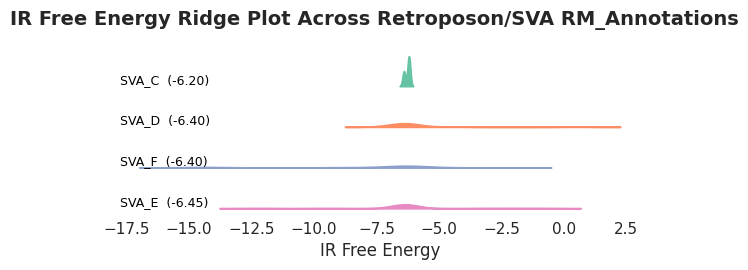

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# -------------------
# Load all haplotype TSVs
# -------------------
input_dir = "/home/alextu/scratch/free_energy_IRS_MEI_sequence_annotated/"
all_files = glob(f"{input_dir}/*.tsv")

dfs = []
for f in all_files:
    df = pd.read_csv(f, sep="\t")
    df = df.drop_duplicates(subset=["Sequence_name"])
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# -------------------
# Preprocess
# -------------------
combined_df['Free_Energy'] = pd.to_numeric(combined_df['Free_Energy'], errors='coerce')
combined_df = combined_df.dropna(subset=['Free_Energy', 'te_designation', 'l1me_aid_info'])
combined_df = combined_df[combined_df["te_designation"] == "Retroposon/SVA"]

# Extract RM_Annotation
combined_df["RM_Annotation"] = combined_df["l1me_aid_info"].str.extract(r"RM_Annotation:([^;]+)")
combined_df = combined_df.dropna(subset=["RM_Annotation"])

# Drop RM_Annotations with no variance
variation = combined_df.groupby("RM_Annotation")["Free_Energy"].nunique()
valid_rms = variation[variation > 1].index.tolist()
combined_df = combined_df[combined_df["RM_Annotation"].isin(valid_rms)]

# Order RM_Annotations
ordered_rms = (
    combined_df.groupby("RM_Annotation", observed=True)["Free_Energy"]
    .median()
    .sort_values(ascending=False)
    .index
    .tolist()
)
combined_df["RM_Annotation"] = pd.Categorical(combined_df["RM_Annotation"], categories=ordered_rms, ordered=True)

# -------------------
# Ridgeline Plot
# -------------------
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Adjust height based on number of categories
height_per_plot = 0.6
g = sns.FacetGrid(
    combined_df,
    row="RM_Annotation",
    hue="RM_Annotation",
    aspect=10,
    height=height_per_plot,
    palette="Set2",
    row_order=ordered_rms
)

g.map(
    sns.kdeplot,
    "Free_Energy",
    bw_adjust=0.6,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.3,
    warn_singular=False
)

# Add median label on left side of each subplot
medians = combined_df.groupby("RM_Annotation", observed=True)["Free_Energy"].median()
for ax, label in zip(g.axes.flat, ordered_rms):
    median_val = medians[label]
    ax.text(0.01, 0.2, f"{label}  ({median_val:.2f})",
            transform=ax.transAxes,
            ha="left", va="center",
            fontsize=9, color="black")

# Final formatting
g.figure.subplots_adjust(hspace=0.3)  # allow spacing
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="IR Free Energy")
g.despine(bottom=True, left=True)

plt.suptitle("IR Free Energy Ridge Plot Across Retroposon/SVA RM_Annotations", fontsize=14, weight='bold', y=1.02)
plt.show()

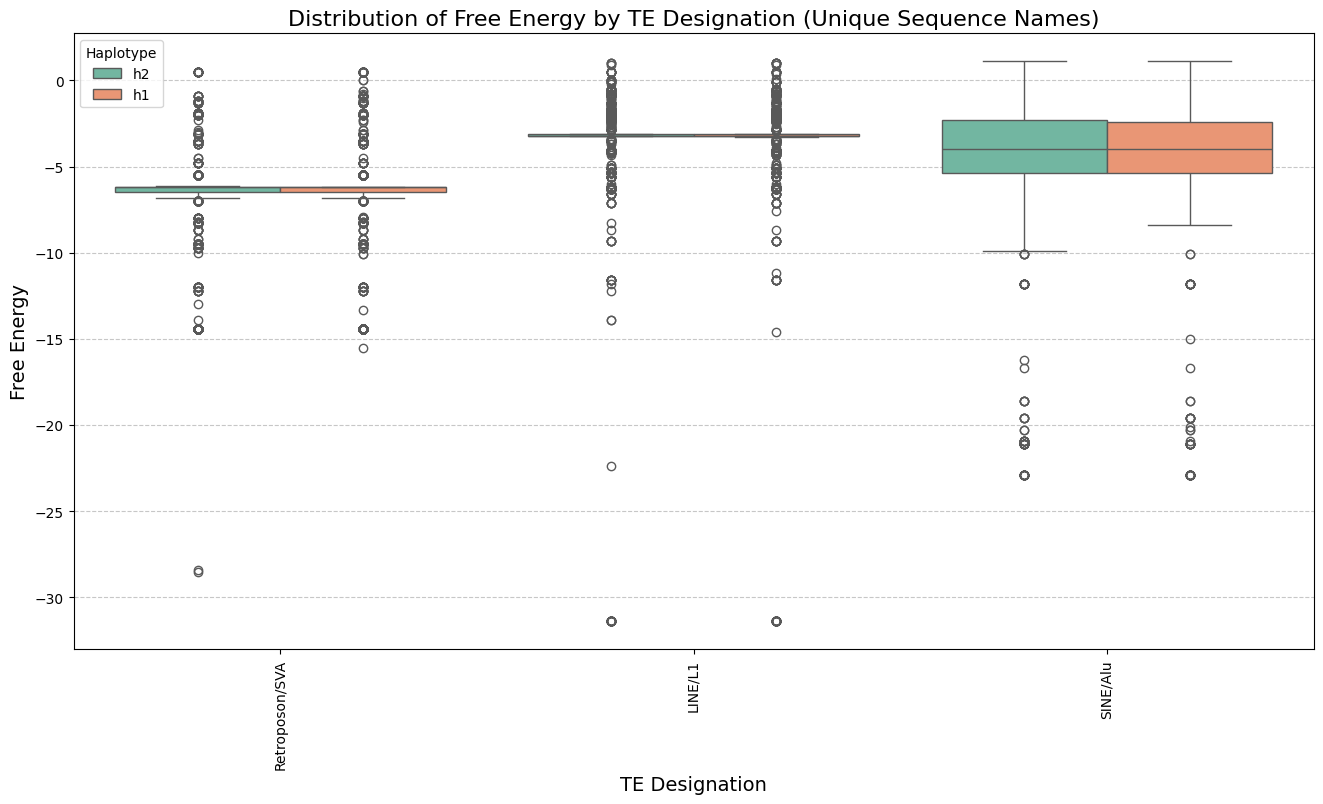

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# -------------------
# Load and Process the Data
# -------------------

# Define the directory containing all TSV files
data_dir = "/home/alextu/scratch/free_energy_IRS_MEI_sequence_annotated/"

# Get all .tsv files in the directory
tsv_files = glob.glob(os.path.join(data_dir, "*.tsv"))

# Initialize an empty list to store dataframes
dataframes = []

# Iterate over each TSV file
for file in tsv_files:
    # Extract sample name and haplotype from filename (e.g., HG00096.h1.MEI_IR_free_energy.tsv)
    filename = os.path.basename(file)
    sample_name = filename.split(".")[0]  # Extracts 'HG00096'
    haplotype = filename.split(".")[1]  # Extracts 'h1' or 'h2'

    # Load the dataset
    df = pd.read_csv(file, sep="\t")

    # Ensure 'Free_Energy' column exists
    if "Free_Energy" not in df.columns:
        print(f"Warning: 'Free_Energy' column not found in {file}, skipping...")
        continue

    # Remove duplicates based on Sequence_name
    df = df.drop_duplicates(subset=["Sequence_name"])

    # Add Haplotype and Sample Name as new columns
    df["Haplotype"] = haplotype
    df["Sample"] = sample_name

    # Append dataframe to list
    dataframes.append(df)

# Combine all dataframes
if not dataframes:
    raise ValueError("No valid data found in the TSV files.")
combined_df = pd.concat(dataframes, ignore_index=True)

# -------------------
# Create Boxplot of Free Energy by TE Designation
# -------------------

plt.figure(figsize=(16, 8))
sns.boxplot(data=combined_df, x="te_designation", y="Free_Energy", hue="Haplotype", palette="Set2")

plt.xlabel("TE Designation", fontsize=14)
plt.ylabel("Free Energy", fontsize=14)
plt.title("Distribution of Free Energy by TE Designation (Unique Sequence Names)", fontsize=16)
plt.xticks(rotation=90)
plt.legend(title="Haplotype")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

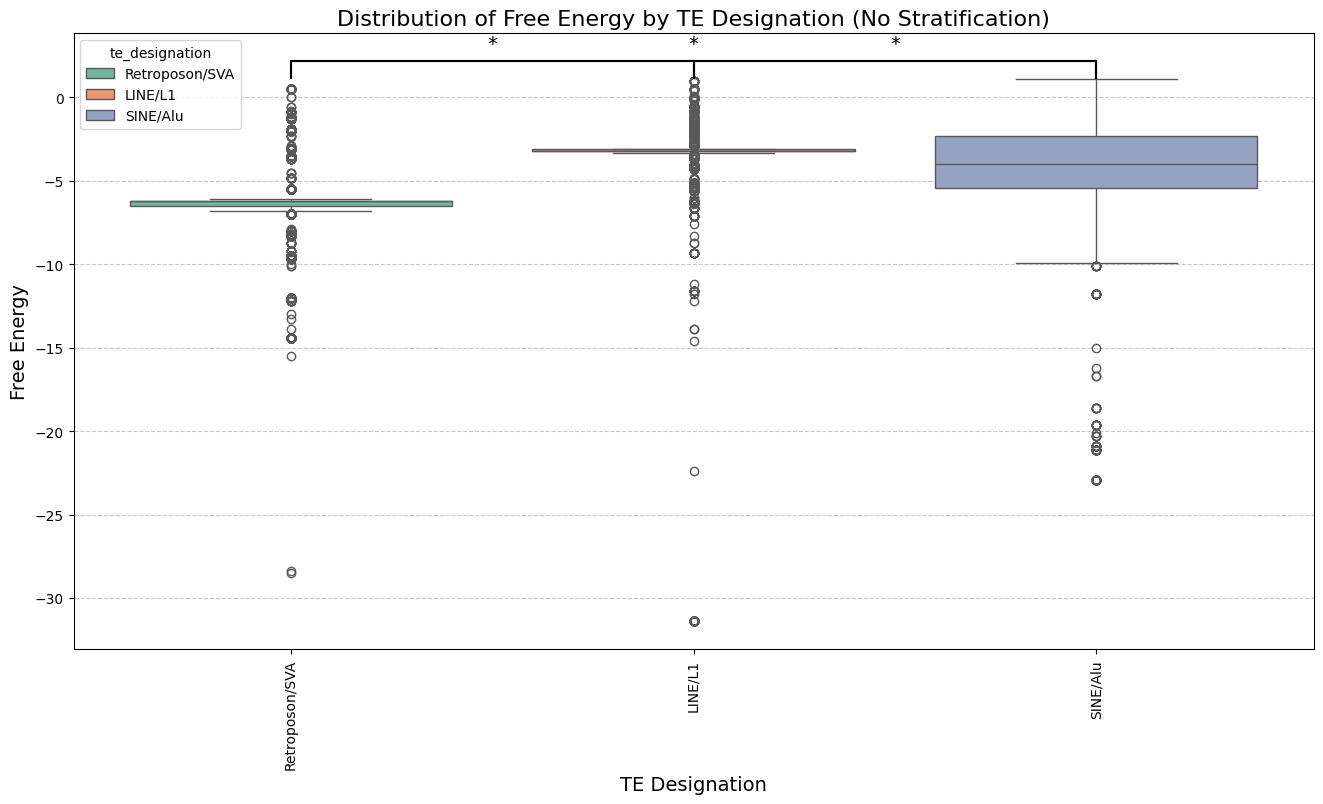

          Group 1   Group 2  KS Statistic        p-value
0  Retroposon/SVA   LINE/L1      0.885753   0.000000e+00
1  Retroposon/SVA  SINE/Alu      0.772396   0.000000e+00
2         LINE/L1  SINE/Alu      0.530307  5.271680e-321


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import ks_2samp
from itertools import combinations

# -------------------
# Load and Process the Data
# -------------------

# Define the directory containing all TSV files
data_dir = "/home/alextu/scratch/free_energy_IRS_MEI_sequence_annotated/"

# Get all .tsv files in the directory
tsv_files = glob.glob(os.path.join(data_dir, "*.tsv"))

# Initialize an empty list to store dataframes
dataframes = []

# Iterate over each TSV file
for file in tsv_files:
    # Extract sample name and haplotype from filename (e.g., HG00096.h1.MEI_IR_free_energy.tsv)
    filename = os.path.basename(file)
    sample_name = filename.split(".")[0]  # Extracts 'HG00096'
    haplotype = filename.split(".")[1]  # Extracts 'h1' or 'h2'

    # Load the dataset
    df = pd.read_csv(file, sep="\t")

    # Ensure 'Free_Energy' column exists
    if "Free_Energy" not in df.columns:
        print(f"Warning: 'Free_Energy' column not found in {file}, skipping...")
        continue

    # Remove duplicates based on Sequence_name
    df = df.drop_duplicates(subset=["Sequence_name"])

    # Append dataframe to list (without adding Haplotype column)
    dataframes.append(df)

# Combine all dataframes
if not dataframes:
    raise ValueError("No valid data found in the TSV files.")
combined_df = pd.concat(dataframes, ignore_index=True)

# -------------------
# Create Boxplot of Free Energy by TE Designation (No Stratification by Haplotype)
# -------------------

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=combined_df, x="te_designation", y="Free_Energy", hue="te_designation", palette="Set2", dodge=False)

plt.xlabel("TE Designation", fontsize=14)
plt.ylabel("Free Energy", fontsize=14)
plt.title("Distribution of Free Energy by TE Designation (No Stratification)", fontsize=16)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# -------------------
# Kolmogorov-Smirnov (KS) Test for Each TE Designation Pair
# -------------------

significance_level = 0.01  # Set significance level to 0.01

tes = list(combined_df["te_designation"].unique())
results = []
significant_pairs = []

for group1, group2 in combinations(tes, 2):
    data1 = combined_df.loc[combined_df["te_designation"] == group1, "Free_Energy"]
    data2 = combined_df.loc[combined_df["te_designation"] == group2, "Free_Energy"]
    
    if len(data1) > 0 and len(data2) > 0:
        stat, p_value = ks_2samp(data1, data2)
        results.append([group1, group2, stat, p_value])
        if p_value < significance_level:
            significant_pairs.append((group1, group2))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Group 1", "Group 2", "KS Statistic", "p-value"])

# Add significance markers to the plot
for group1, group2 in significant_pairs:
    x1, x2 = tes.index(group1), tes.index(group2)
    y_max = combined_df["Free_Energy"].max() * 1.05
    plt.plot([x1, x1, x2, x2], [y_max, y_max + 1, y_max + 1, y_max], lw=1.5, c='black')
    plt.text((x1 + x2) * 0.5, y_max + 1.5, "*", ha='center', va='bottom', fontsize=14, color='black')

plt.show()

# Display results
print(results_df)